In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

%matplotlib inline

In [2]:
import math
# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# function to extract features from a list of images
# Wrapper function for all features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# function to extract features from a single image window
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
#################################################################################################################

   

In [3]:
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# Read in cars and notcars
vehicle_images = glob.glob('vehicles/**/*.png')
non_vehicle_images = glob.glob('non-vehicles/**/*.png')

print(len(vehicle_images), len(non_vehicle_images))

8792 8968


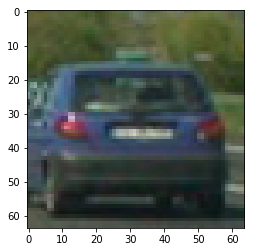

In [4]:
cars = []
notcars = []
for vimage, nvimage in zip(vehicle_images, non_vehicle_images):
    notcars.append(nvimage)
    cars.append(vimage)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#test code to try various operations on a single image
testimg = mpimg.imread('vehicles/GTI_Right/image0211.png')
plt.imshow(testimg)

C:\Users\chinmayd\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


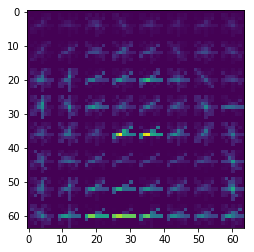

In [5]:
feature_image = cv2.cvtColor(testimg, cv2.COLOR_RGB2LUV)
feat,hogimg = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.imshow(hogimg)

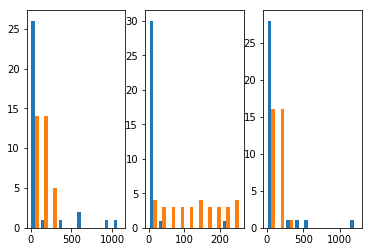

In [6]:
channel1_hist = np.histogram(feature_image[:,:,0], bins=32, range=(0, 256))
channel2_hist = np.histogram(feature_image[:,:,1], bins=32, range=(0, 256))
channel3_hist = np.histogram(feature_image[:,:,2], bins=32, range=(0, 256))
plt.subplot(131)
plt.hist(channel1_hist)
plt.subplot(132)
plt.hist(channel2_hist)
plt.subplot(133)
plt.hist(channel3_hist)
plt.show()

In [7]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

C:\Users\chinmayd\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
5.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9794


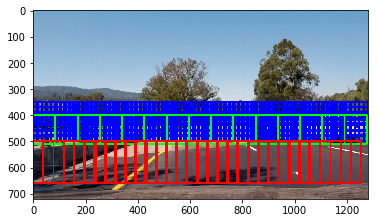

In [8]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)
y_start_stop_far = [350, 500]
y_start_stop_mid = [400, 550] # Min and max in y to search in slide_window()
y_start_stop_near = [500, 700]

image = image.astype(np.float32)/255

#create window sets

windows_far = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_far, 
                    xy_window=(90, 68), xy_overlap=(0.8, 0.7))

windows_mid = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_mid, 
                    xy_window=(170, 110), xy_overlap=(0.5, 0.5))

windows_near = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_near, 
                    xy_window=(200, 160), xy_overlap=(0.8, 0.5))
search_windows_img = draw_boxes(draw_image, windows_far, color=(0, 0, 255), thick=8) 
search_windows_img = draw_boxes(search_windows_img, windows_mid, color=(0, 255, 0), thick=6) 
search_windows_img = draw_boxes(search_windows_img, windows_near, color=(255, 0, 0), thick=6) 
windows = []
windows = windows_near + windows_far + windows_mid
plt.imshow(search_windows_img)

C:\Users\chinmayd\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


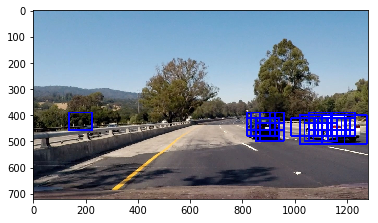

In [9]:
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #remove small/thin boxes
        if((bbox[1][0] - bbox[0][0] < 60) or (bbox[1][1] - bbox[0][1] < 60)):
            continue
        #print(bbox)
        #print((bbox[1][0] - bbox[0][0] ), (bbox[1][1] - bbox[0][1]))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bboxes=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #remove small/thin boxes
        if((bbox[1][0] - bbox[0][0] < 60) or (bbox[1][1] - bbox[0][1] < 60)):
            continue
        print(bbox)
        bboxes.append(bbox)
    # Return the image
    return bboxes

def draw_bboxes(img, bboxes):
    # Iterate through all detected cars
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 0) <class 'tuple'>


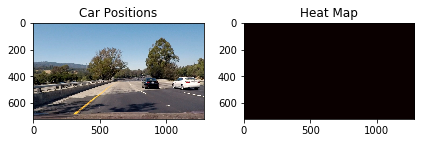

In [11]:
from scipy.ndimage.measurements import label
heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,40)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels, type(labels))

draw_img = draw_labeled_bboxes(np.copy(draw_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections

In [21]:
#saves heatmaps from previous 8 frames.
historic_heatmaps = collections.deque(maxlen=8)

#main pipeline
def process_image(image):
    y_start_stop_far = [400, 500]
    y_start_stop_mid = [400, 550] # Min and max in y to search in slide_window()
    y_start_stop_near = [400, 700]

    image = image.astype(np.float32)/255

    windows_far = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_far, 
                    xy_window=(80, 60), xy_overlap=(0.8, 0.7))

    windows_mid = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_mid, 
                    xy_window=(170, 110), xy_overlap=(0.8, 0.5))

    windows_near = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_near, 
                    xy_window=(200, 160), xy_overlap=(0.8, 0.5))

    windows = []
    windows = windows_near + windows_far + windows_mid
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    heatmap_sum = sum(historic_heatmaps)
    if(len(historic_heatmaps) == 0):
        historic_heatmaps.append(heat) #this will happen for initial frame to avoid empty history
    heatmap_sum_filtered= heatmap_sum*0.5 + heat*0.5
    
    # Apply threshold to help remove false positives
    t_heat = apply_threshold(heatmap_sum_filtered, 9)
    historic_heatmaps.append(heat)


    # Find final boxes from heatmap using label function
    labels = label(t_heat)
    current_bboxes = get_labeled_bboxes(labels) #also removes some false positive/'thin' boxes
    
    #ret_img = draw_labeled_bboxes(np.copy(image), labels)
    ret_img = draw_bboxes(np.copy(image), current_bboxes)
    return ret_img*255

    

In [22]:
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


  2%|▏         | 25/1261 [00:15<13:22,  1.54it/s]

((507, 480), (589, 559))


  2%|▏         | 26/1261 [00:16<13:10,  1.56it/s]

((507, 480), (589, 559))


  4%|▍         | 50/1261 [00:32<13:27,  1.50it/s]

((510, 480), (589, 559))


  4%|▍         | 51/1261 [00:33<13:05,  1.54it/s]

((510, 480), (589, 559))


  4%|▍         | 52/1261 [00:33<12:56,  1.56it/s]

((510, 480), (589, 559))


  4%|▍         | 53/1261 [00:34<12:49,  1.57it/s]

((510, 480), (589, 559))


  4%|▍         | 54/1261 [00:35<12:43,  1.58it/s]

((507, 480), (589, 559))


  4%|▍         | 55/1261 [00:35<12:48,  1.57it/s]

((507, 480), (589, 639))


  4%|▍         | 56/1261 [00:36<12:44,  1.58it/s]

((507, 480), (589, 639))


  5%|▍         | 57/1261 [00:37<12:37,  1.59it/s]

((507, 480), (589, 639))


  5%|▍         | 58/1261 [00:37<12:36,  1.59it/s]

((507, 480), (589, 559))


 11%|█▏        | 144/1261 [01:31<11:48,  1.58it/s]

((507, 480), (589, 639))


 13%|█▎        | 163/1261 [01:44<12:16,  1.49it/s]

((1185, 400), (1264, 477))


 13%|█▎        | 164/1261 [01:45<12:07,  1.51it/s]

((1170, 400), (1264, 477))


 13%|█▎        | 165/1261 [01:45<12:05,  1.51it/s]

((1170, 400), (1264, 477))


 13%|█▎        | 166/1261 [01:46<12:07,  1.50it/s]

((1170, 400), (1264, 477))


 13%|█▎        | 167/1261 [01:47<12:11,  1.50it/s]

((1170, 400), (1264, 477))


 13%|█▎        | 168/1261 [01:47<12:11,  1.50it/s]

((1170, 400), (1264, 477))


 13%|█▎        | 169/1261 [01:48<12:06,  1.50it/s]

((1155, 400), (1264, 477))


 13%|█▎        | 170/1261 [01:49<12:03,  1.51it/s]

((1155, 400), (1264, 495))


 14%|█▎        | 171/1261 [01:49<12:31,  1.45it/s]

((1155, 400), (1264, 495))


 14%|█▎        | 172/1261 [01:50<13:13,  1.37it/s]

((1155, 400), (1264, 495))


 14%|█▎        | 173/1261 [01:51<12:50,  1.41it/s]

((1140, 400), (1264, 495))


 14%|█▍        | 174/1261 [01:51<12:27,  1.45it/s]

((1140, 400), (1264, 495))


 14%|█▍        | 175/1261 [01:52<12:21,  1.46it/s]

((1140, 400), (1264, 495))


 14%|█▍        | 176/1261 [01:53<12:37,  1.43it/s]

((1140, 400), (1264, 495))


 14%|█▍        | 177/1261 [01:53<12:22,  1.46it/s]

((1140, 400), (1264, 495))


 14%|█▍        | 178/1261 [01:54<12:16,  1.47it/s]

((1125, 400), (1264, 495))


 14%|█▍        | 179/1261 [01:55<12:13,  1.47it/s]

((1095, 400), (1264, 495))


 14%|█▍        | 180/1261 [01:55<12:08,  1.48it/s]

((1089, 400), (1264, 495))


 14%|█▍        | 181/1261 [01:56<13:58,  1.29it/s]

((1089, 400), (1264, 495))


 14%|█▍        | 182/1261 [01:57<13:32,  1.33it/s]

((1089, 400), (1264, 509))


 15%|█▍        | 183/1261 [01:58<13:22,  1.34it/s]

((1089, 400), (1264, 509))


 15%|█▍        | 184/1261 [01:59<13:13,  1.36it/s]

((1089, 400), (1264, 509))


 15%|█▍        | 185/1261 [01:59<13:09,  1.36it/s]

((1089, 400), (1264, 509))


 15%|█▍        | 186/1261 [02:00<13:08,  1.36it/s]

((1080, 400), (1264, 509))


 15%|█▍        | 187/1261 [02:01<12:45,  1.40it/s]

((1080, 400), (1264, 509))


 15%|█▍        | 188/1261 [02:01<12:35,  1.42it/s]

((1080, 400), (1264, 509))


 15%|█▍        | 189/1261 [02:02<13:18,  1.34it/s]

((1080, 400), (1258, 509))


 15%|█▌        | 190/1261 [02:03<14:16,  1.25it/s]

((1080, 400), (1258, 509))


 15%|█▌        | 191/1261 [02:04<14:44,  1.21it/s]

((1080, 400), (1258, 509))


 15%|█▌        | 192/1261 [02:05<13:59,  1.27it/s]

((1080, 400), (1258, 509))


 15%|█▌        | 193/1261 [02:05<13:27,  1.32it/s]

((1080, 400), (1258, 509))


 15%|█▌        | 194/1261 [02:06<13:01,  1.36it/s]

((1080, 400), (1258, 509))


 15%|█▌        | 195/1261 [02:07<12:46,  1.39it/s]

((1089, 400), (1258, 509))


 16%|█▌        | 196/1261 [02:07<12:20,  1.44it/s]

((1089, 400), (1258, 509))


 16%|█▌        | 197/1261 [02:08<12:08,  1.46it/s]

((1089, 400), (1258, 509))


 16%|█▌        | 198/1261 [02:09<12:07,  1.46it/s]

((1089, 400), (1258, 509))


 16%|█▌        | 199/1261 [02:10<12:10,  1.45it/s]

((1089, 400), (1258, 509))


 16%|█▌        | 200/1261 [02:10<12:04,  1.46it/s]

((1056, 400), (1264, 509))


 16%|█▌        | 201/1261 [02:11<11:56,  1.48it/s]

((1056, 400), (1264, 509))


 16%|█▌        | 202/1261 [02:12<11:54,  1.48it/s]

((1056, 400), (1264, 509))


 16%|█▌        | 203/1261 [02:12<11:50,  1.49it/s]

((1056, 400), (1264, 509))


 16%|█▌        | 204/1261 [02:13<11:42,  1.50it/s]

((1056, 400), (1264, 509))


 16%|█▋        | 205/1261 [02:13<11:36,  1.52it/s]

((1056, 400), (1264, 509))


 16%|█▋        | 206/1261 [02:14<11:32,  1.52it/s]

((1053, 400), (1264, 509))


 16%|█▋        | 207/1261 [02:15<11:27,  1.53it/s]

((1053, 400), (1258, 509))


 16%|█▋        | 208/1261 [02:15<11:24,  1.54it/s]

((1053, 400), (1258, 509))


 17%|█▋        | 209/1261 [02:16<11:21,  1.54it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 210/1261 [02:17<11:21,  1.54it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 211/1261 [02:17<11:22,  1.54it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 212/1261 [02:18<11:20,  1.54it/s]

((1056, 400), (1252, 509))


 17%|█▋        | 213/1261 [02:19<11:19,  1.54it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 214/1261 [02:19<11:23,  1.53it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 215/1261 [02:20<11:41,  1.49it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 216/1261 [02:21<11:39,  1.49it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 217/1261 [02:21<11:35,  1.50it/s]

((1053, 400), (1252, 509))


 17%|█▋        | 218/1261 [02:22<11:34,  1.50it/s]

((1053, 400), (1258, 509))


 17%|█▋        | 219/1261 [02:23<11:28,  1.51it/s]

((1053, 400), (1264, 509))


 17%|█▋        | 220/1261 [02:23<11:56,  1.45it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 221/1261 [02:24<11:44,  1.48it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 222/1261 [02:25<11:32,  1.50it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 223/1261 [02:25<11:26,  1.51it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 224/1261 [02:26<11:18,  1.53it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 225/1261 [02:27<11:16,  1.53it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 226/1261 [02:27<11:14,  1.54it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 227/1261 [02:28<11:10,  1.54it/s]

((1053, 400), (1264, 509))


 18%|█▊        | 228/1261 [02:29<11:09,  1.54it/s]

((1053, 400), (1258, 509))


 18%|█▊        | 229/1261 [02:29<11:08,  1.54it/s]

((1053, 400), (1258, 509))


 18%|█▊        | 230/1261 [02:30<12:07,  1.42it/s]

((1035, 400), (1258, 509))


 18%|█▊        | 231/1261 [02:31<12:41,  1.35it/s]

((1035, 400), (1258, 509))


 18%|█▊        | 232/1261 [02:32<12:56,  1.32it/s]

((1035, 400), (1258, 509))


 18%|█▊        | 233/1261 [02:33<13:15,  1.29it/s]

((1035, 400), (1258, 509))


 19%|█▊        | 234/1261 [02:33<13:12,  1.30it/s]

((1035, 400), (1258, 509))


 19%|█▊        | 235/1261 [02:34<12:51,  1.33it/s]

((1023, 400), (1258, 509))


 19%|█▊        | 236/1261 [02:35<12:23,  1.38it/s]

((1023, 400), (1258, 509))


 19%|█▉        | 237/1261 [02:35<12:00,  1.42it/s]

((1023, 400), (1252, 509))


 19%|█▉        | 238/1261 [02:36<11:42,  1.46it/s]

((1023, 400), (1252, 509))


 19%|█▉        | 239/1261 [02:37<11:28,  1.49it/s]

((1023, 400), (1252, 509))


 19%|█▉        | 240/1261 [02:37<11:58,  1.42it/s]

((1023, 400), (1249, 509))


 19%|█▉        | 241/1261 [02:38<12:56,  1.31it/s]

((1014, 400), (1249, 509))


 19%|█▉        | 242/1261 [02:39<12:39,  1.34it/s]

((990, 400), (1249, 509))


 19%|█▉        | 243/1261 [02:40<12:24,  1.37it/s]

((990, 400), (1249, 509))


 19%|█▉        | 244/1261 [02:40<11:58,  1.42it/s]

((990, 400), (1249, 509))


 19%|█▉        | 245/1261 [02:41<11:39,  1.45it/s]

((990, 400), (1249, 509))


 20%|█▉        | 246/1261 [02:42<11:25,  1.48it/s]

((990, 400), (1249, 509))


 20%|█▉        | 247/1261 [02:42<11:26,  1.48it/s]

((990, 400), (1249, 509))


 20%|█▉        | 248/1261 [02:43<11:44,  1.44it/s]

((1020, 400), (1249, 509))


 20%|█▉        | 249/1261 [02:44<11:53,  1.42it/s]

((1020, 400), (1249, 509))


 20%|█▉        | 250/1261 [02:44<11:59,  1.41it/s]

((1020, 400), (1249, 509))


 20%|█▉        | 251/1261 [02:45<11:48,  1.43it/s]

((1014, 400), (1249, 509))


 20%|█▉        | 252/1261 [02:46<11:41,  1.44it/s]

((1014, 400), (1249, 509))


 20%|██        | 253/1261 [02:47<11:36,  1.45it/s]

((1014, 400), (1234, 509))


 20%|██        | 254/1261 [02:47<11:45,  1.43it/s]

((1014, 400), (1234, 509))


 20%|██        | 255/1261 [02:48<11:50,  1.42it/s]

((1014, 400), (1234, 509))


 20%|██        | 256/1261 [02:49<12:03,  1.39it/s]

((1014, 400), (1234, 559))


 20%|██        | 257/1261 [02:49<12:09,  1.38it/s]

((1014, 400), (1234, 559))


 20%|██        | 258/1261 [02:50<12:16,  1.36it/s]

((1014, 400), (1234, 559))


 21%|██        | 259/1261 [02:51<12:27,  1.34it/s]

((1014, 400), (1234, 559))


 21%|██        | 260/1261 [02:52<12:50,  1.30it/s]

((1014, 400), (1252, 559))


 21%|██        | 261/1261 [02:53<13:11,  1.26it/s]

((1014, 400), (1252, 559))


 21%|██        | 262/1261 [02:53<13:26,  1.24it/s]

((1014, 400), (1252, 509))


 21%|██        | 263/1261 [02:54<12:50,  1.30it/s]

((990, 400), (1252, 509))


 21%|██        | 264/1261 [02:55<12:16,  1.35it/s]

((990, 400), (1252, 509))


 21%|██        | 265/1261 [02:56<12:06,  1.37it/s]

((990, 400), (1252, 559))


 21%|██        | 266/1261 [02:56<11:40,  1.42it/s]

((990, 400), (1252, 559))


 21%|██        | 267/1261 [02:57<11:29,  1.44it/s]

((990, 400), (1252, 559))


 21%|██▏       | 268/1261 [02:58<11:16,  1.47it/s]

((990, 400), (1252, 559))


 21%|██▏       | 269/1261 [02:58<11:16,  1.47it/s]

((990, 400), (1252, 559))


 21%|██▏       | 270/1261 [02:59<11:59,  1.38it/s]

((990, 400), (1252, 559))


 21%|██▏       | 271/1261 [03:00<12:55,  1.28it/s]

((990, 400), (1252, 559))


 22%|██▏       | 272/1261 [03:01<12:40,  1.30it/s]

((990, 400), (1252, 559))


 22%|██▏       | 273/1261 [03:01<12:27,  1.32it/s]

((990, 400), (1252, 559))


 22%|██▏       | 274/1261 [03:02<12:10,  1.35it/s]

((990, 400), (1252, 559))


 22%|██▏       | 275/1261 [03:03<12:04,  1.36it/s]

((990, 400), (1252, 559))


 22%|██▏       | 276/1261 [03:04<11:52,  1.38it/s]

((990, 400), (1252, 559))


 22%|██▏       | 277/1261 [03:04<11:37,  1.41it/s]

((990, 400), (1252, 559))


 22%|██▏       | 278/1261 [03:05<11:39,  1.41it/s]

((990, 400), (1252, 559))


 22%|██▏       | 279/1261 [03:06<12:05,  1.35it/s]

((990, 400), (1252, 559))


 22%|██▏       | 280/1261 [03:06<12:11,  1.34it/s]

((1005, 400), (1249, 559))


 22%|██▏       | 281/1261 [03:07<12:01,  1.36it/s]

((1005, 400), (1249, 559))


 22%|██▏       | 282/1261 [03:08<11:46,  1.39it/s]

((990, 400), (1249, 559))


 22%|██▏       | 283/1261 [03:09<12:11,  1.34it/s]

((990, 400), (1249, 559))


 23%|██▎       | 284/1261 [03:09<12:22,  1.32it/s]

((990, 400), (1249, 559))


 23%|██▎       | 285/1261 [03:10<12:07,  1.34it/s]

((990, 400), (1234, 559))


 23%|██▎       | 286/1261 [03:11<11:47,  1.38it/s]

((990, 400), (1225, 509))


 23%|██▎       | 287/1261 [03:12<11:27,  1.42it/s]

((990, 400), (1225, 509))


 23%|██▎       | 288/1261 [03:12<11:13,  1.44it/s]

((990, 400), (1225, 509))


 23%|██▎       | 289/1261 [03:13<11:02,  1.47it/s]

((975, 400), (1225, 509))


 23%|██▎       | 290/1261 [03:14<10:52,  1.49it/s]

((975, 400), (1225, 509))


 23%|██▎       | 291/1261 [03:14<10:40,  1.51it/s]

((960, 400), (1225, 509))


 23%|██▎       | 292/1261 [03:15<10:36,  1.52it/s]

((960, 400), (1225, 509))


 23%|██▎       | 293/1261 [03:15<10:34,  1.53it/s]

((960, 400), (1234, 509))


 23%|██▎       | 294/1261 [03:16<10:53,  1.48it/s]

((960, 400), (1234, 509))


 23%|██▎       | 295/1261 [03:17<11:10,  1.44it/s]

((960, 400), (1225, 509))


 23%|██▎       | 296/1261 [03:18<11:55,  1.35it/s]

((960, 400), (1225, 509))


 24%|██▎       | 297/1261 [03:18<11:55,  1.35it/s]

((960, 400), (1225, 509))


 24%|██▎       | 298/1261 [03:19<11:34,  1.39it/s]

((960, 400), (1225, 509))


 24%|██▎       | 299/1261 [03:20<11:16,  1.42it/s]

((960, 400), (1225, 509))


 24%|██▍       | 300/1261 [03:20<11:05,  1.45it/s]

((960, 400), (1225, 509))


 24%|██▍       | 301/1261 [03:21<11:02,  1.45it/s]

((960, 400), (1219, 509))


 24%|██▍       | 302/1261 [03:22<10:56,  1.46it/s]

((975, 400), (1219, 509))


 24%|██▍       | 303/1261 [03:23<10:54,  1.46it/s]

((975, 400), (1219, 509))


 24%|██▍       | 304/1261 [03:23<11:27,  1.39it/s]

((975, 400), (1219, 509))


 24%|██▍       | 305/1261 [03:24<11:19,  1.41it/s]

((975, 400), (1219, 509))


 24%|██▍       | 306/1261 [03:25<10:58,  1.45it/s]

((975, 400), (1219, 509))


 24%|██▍       | 307/1261 [03:25<11:07,  1.43it/s]

((975, 400), (1219, 509))


 24%|██▍       | 308/1261 [03:26<11:38,  1.36it/s]

((975, 400), (1219, 509))


 25%|██▍       | 309/1261 [03:27<11:35,  1.37it/s]

((975, 400), (1219, 509))


 25%|██▍       | 310/1261 [03:28<11:21,  1.40it/s]

((990, 400), (1213, 509))


 25%|██▍       | 311/1261 [03:28<11:12,  1.41it/s]

((990, 400), (1213, 509))


 25%|██▍       | 312/1261 [03:29<11:09,  1.42it/s]

((990, 400), (1213, 509))


 25%|██▍       | 313/1261 [03:30<11:02,  1.43it/s]

((990, 400), (1213, 509))


 25%|██▍       | 314/1261 [03:30<10:59,  1.44it/s]

((990, 400), (1213, 509))


 25%|██▍       | 315/1261 [03:31<10:52,  1.45it/s]

((990, 400), (1213, 509))


 25%|██▌       | 316/1261 [03:32<10:49,  1.46it/s]

((990, 400), (1213, 509))


 25%|██▌       | 317/1261 [03:32<11:07,  1.41it/s]

((990, 400), (1213, 509))


 25%|██▌       | 318/1261 [03:33<11:15,  1.40it/s]

((990, 400), (1204, 509))


 25%|██▌       | 319/1261 [03:34<11:22,  1.38it/s]

((975, 400), (1204, 509))


 25%|██▌       | 320/1261 [03:35<11:34,  1.35it/s]

((975, 400), (1204, 509))


 25%|██▌       | 321/1261 [03:35<11:28,  1.37it/s]

((975, 400), (1204, 509))


 26%|██▌       | 322/1261 [03:36<11:22,  1.38it/s]

((960, 400), (1204, 509))


 26%|██▌       | 323/1261 [03:37<10:59,  1.42it/s]

((960, 400), (1204, 509))


 26%|██▌       | 324/1261 [03:37<10:45,  1.45it/s]

((975, 400), (1204, 509))


 26%|██▌       | 325/1261 [03:38<10:29,  1.49it/s]

((975, 400), (1204, 509))


 26%|██▌       | 326/1261 [03:39<10:18,  1.51it/s]

((975, 400), (1213, 509))


 26%|██▌       | 327/1261 [03:39<10:09,  1.53it/s]

((975, 400), (1213, 509))


 26%|██▌       | 328/1261 [03:40<10:10,  1.53it/s]

((957, 400), (1213, 509))


 26%|██▌       | 329/1261 [03:41<10:06,  1.54it/s]

((957, 400), (1213, 509))


 26%|██▌       | 330/1261 [03:41<10:01,  1.55it/s]

((957, 400), (1192, 509))


 26%|██▌       | 331/1261 [03:42<09:57,  1.56it/s]

((975, 400), (1192, 509))


 26%|██▋       | 332/1261 [03:43<10:08,  1.53it/s]

((975, 400), (1192, 509))


 26%|██▋       | 333/1261 [03:43<10:08,  1.53it/s]

((957, 400), (1192, 509))


 26%|██▋       | 334/1261 [03:44<10:05,  1.53it/s]

((975, 400), (1192, 509))


 27%|██▋       | 335/1261 [03:45<10:06,  1.53it/s]

((957, 400), (1192, 509))


 27%|██▋       | 336/1261 [03:45<10:06,  1.52it/s]

((957, 400), (1192, 509))


 27%|██▋       | 337/1261 [03:46<10:06,  1.52it/s]

((957, 400), (1192, 509))


 27%|██▋       | 338/1261 [03:47<10:03,  1.53it/s]

((957, 400), (1192, 509))


 27%|██▋       | 339/1261 [03:47<10:02,  1.53it/s]

((957, 400), (1192, 509))


 27%|██▋       | 340/1261 [03:48<09:59,  1.54it/s]

((957, 400), (1192, 509))


 27%|██▋       | 341/1261 [03:49<10:19,  1.48it/s]

((957, 400), (1219, 509))


 27%|██▋       | 342/1261 [03:49<10:26,  1.47it/s]

((975, 400), (1225, 509))


 27%|██▋       | 343/1261 [03:50<10:28,  1.46it/s]

((957, 400), (1225, 509))


 27%|██▋       | 344/1261 [03:51<10:19,  1.48it/s]

((975, 400), (1234, 509))


 27%|██▋       | 345/1261 [03:51<11:07,  1.37it/s]

((975, 400), (1249, 509))


 27%|██▋       | 346/1261 [03:52<11:04,  1.38it/s]

((975, 400), (1249, 509))


 28%|██▊       | 347/1261 [03:53<10:49,  1.41it/s]

((975, 400), (1249, 509))


 28%|██▊       | 348/1261 [03:54<11:05,  1.37it/s]

((975, 400), (1249, 509))


 28%|██▊       | 349/1261 [03:54<10:54,  1.39it/s]

((975, 400), (1249, 509))


 28%|██▊       | 350/1261 [03:55<10:44,  1.41it/s]

((975, 400), (1249, 509))


 28%|██▊       | 351/1261 [03:56<10:25,  1.45it/s]

((975, 400), (1234, 509))


 28%|██▊       | 352/1261 [03:56<11:00,  1.38it/s]

((975, 400), (1192, 509))


 28%|██▊       | 353/1261 [03:57<11:22,  1.33it/s]

((975, 400), (1174, 509))


 28%|██▊       | 354/1261 [03:58<11:07,  1.36it/s]

((975, 400), (1174, 509))


 28%|██▊       | 355/1261 [03:59<10:45,  1.40it/s]

((975, 400), (1174, 509))


 28%|██▊       | 356/1261 [03:59<11:07,  1.36it/s]

((975, 400), (1174, 509))


 28%|██▊       | 357/1261 [04:00<11:13,  1.34it/s]

((975, 400), (1159, 509))


 28%|██▊       | 358/1261 [04:01<11:13,  1.34it/s]

((975, 400), (1159, 509))


 28%|██▊       | 359/1261 [04:02<11:10,  1.35it/s]

((975, 400), (1159, 509))


 29%|██▊       | 360/1261 [04:02<11:05,  1.35it/s]

((975, 400), (1159, 509))


 29%|██▊       | 361/1261 [04:03<10:40,  1.41it/s]

((975, 400), (1159, 509))


 29%|██▊       | 362/1261 [04:04<10:19,  1.45it/s]

((975, 400), (1159, 509))


 29%|██▉       | 363/1261 [04:04<10:41,  1.40it/s]

((975, 400), (1159, 509))


 29%|██▉       | 364/1261 [04:05<10:27,  1.43it/s]

((960, 400), (1159, 509))


 29%|██▉       | 365/1261 [04:06<10:16,  1.45it/s]

((957, 400), (1159, 509))


 29%|██▉       | 366/1261 [04:06<10:13,  1.46it/s]

((957, 400), (1159, 509))


 29%|██▉       | 367/1261 [04:07<10:03,  1.48it/s]

((957, 400), (1174, 509))


 29%|██▉       | 368/1261 [04:08<09:56,  1.50it/s]

((957, 400), (1189, 509))


 29%|██▉       | 369/1261 [04:08<09:48,  1.52it/s]

((957, 400), (1192, 509))


 29%|██▉       | 370/1261 [04:09<09:41,  1.53it/s]

((957, 400), (1192, 509))


 29%|██▉       | 371/1261 [04:10<09:42,  1.53it/s]

((957, 400), (1204, 509))


 30%|██▉       | 372/1261 [04:10<09:53,  1.50it/s]

((957, 400), (1219, 509))


 30%|██▉       | 373/1261 [04:11<10:20,  1.43it/s]

((957, 400), (1219, 509))


 30%|██▉       | 374/1261 [04:12<10:21,  1.43it/s]

((957, 400), (1219, 509))


 30%|██▉       | 375/1261 [04:13<10:15,  1.44it/s]

((957, 400), (1234, 509))


 30%|██▉       | 376/1261 [04:13<10:01,  1.47it/s]

((957, 400), (1234, 509))


 30%|██▉       | 377/1261 [04:14<09:52,  1.49it/s]

((957, 400), (1234, 509))


 30%|██▉       | 378/1261 [04:14<09:41,  1.52it/s]

((957, 400), (1234, 509))


 30%|███       | 379/1261 [04:15<09:35,  1.53it/s]

((957, 400), (1234, 509))


 30%|███       | 380/1261 [04:16<09:34,  1.53it/s]

((945, 400), (1234, 509))


 30%|███       | 381/1261 [04:16<09:34,  1.53it/s]

((945, 400), (1234, 509))


 30%|███       | 382/1261 [04:17<09:58,  1.47it/s]

((945, 400), (1234, 495))


 30%|███       | 383/1261 [04:18<10:08,  1.44it/s]

((945, 400), (1234, 509))


 30%|███       | 384/1261 [04:19<09:59,  1.46it/s]

((945, 400), (1234, 509))


 31%|███       | 385/1261 [04:19<09:47,  1.49it/s]

((945, 400), (1234, 509))


 31%|███       | 386/1261 [04:20<10:13,  1.43it/s]

((945, 400), (1234, 509))


 31%|███       | 387/1261 [04:21<10:00,  1.45it/s]

((945, 400), (1234, 509))


 31%|███       | 388/1261 [04:21<09:48,  1.48it/s]

((945, 400), (1234, 509))


 31%|███       | 389/1261 [04:22<10:02,  1.45it/s]

((945, 400), (1219, 509))


 31%|███       | 390/1261 [04:23<10:34,  1.37it/s]

((945, 400), (1219, 509))


 31%|███       | 391/1261 [04:24<10:40,  1.36it/s]

((945, 400), (1234, 509))


 31%|███       | 392/1261 [04:24<10:43,  1.35it/s]

((930, 400), (1219, 509))


 31%|███       | 393/1261 [04:25<10:58,  1.32it/s]

((930, 400), (1093, 495))


 31%|███       | 394/1261 [04:26<10:56,  1.32it/s]

((930, 400), (1093, 495))


 31%|███▏      | 395/1261 [04:27<10:49,  1.33it/s]

((930, 400), (1093, 495))


 31%|███▏      | 396/1261 [04:27<10:33,  1.36it/s]

((930, 400), (1093, 495))


 31%|███▏      | 397/1261 [04:28<10:51,  1.33it/s]

((930, 400), (1093, 495))


 32%|███▏      | 398/1261 [04:29<10:37,  1.35it/s]

((930, 400), (1093, 509))


 32%|███▏      | 399/1261 [04:29<10:19,  1.39it/s]

((930, 400), (1093, 509))


 32%|███▏      | 400/1261 [04:30<10:00,  1.43it/s]

((924, 400), (1093, 509))


 32%|███▏      | 401/1261 [04:31<09:58,  1.44it/s]

((924, 400), (1093, 509))


 32%|███▏      | 402/1261 [04:32<10:00,  1.43it/s]

((924, 400), (1093, 509))


 32%|███▏      | 403/1261 [04:32<09:48,  1.46it/s]

((924, 400), (1093, 509))


 32%|███▏      | 404/1261 [04:33<09:43,  1.47it/s]

((924, 400), (1093, 509))


 32%|███▏      | 405/1261 [04:34<09:34,  1.49it/s]

((924, 400), (1093, 509))


 32%|███▏      | 406/1261 [04:34<09:24,  1.51it/s]

((924, 400), (1093, 509))


 32%|███▏      | 407/1261 [04:35<09:17,  1.53it/s]

((924, 400), (1093, 509))


 32%|███▏      | 408/1261 [04:35<09:14,  1.54it/s]

((915, 400), (1093, 509))


 32%|███▏      | 409/1261 [04:36<09:13,  1.54it/s]

((915, 400), (1093, 509))


 33%|███▎      | 410/1261 [04:37<09:14,  1.53it/s]

((915, 400), (1093, 509))


 33%|███▎      | 411/1261 [04:37<09:16,  1.53it/s]

((915, 400), (1069, 509))


 33%|███▎      | 412/1261 [04:38<09:18,  1.52it/s]

((915, 400), (1093, 509))


 33%|███▎      | 413/1261 [04:39<09:14,  1.53it/s]

((915, 400), (1093, 509))


 33%|███▎      | 414/1261 [04:39<09:11,  1.54it/s]

((915, 400), (1093, 509))


 33%|███▎      | 415/1261 [04:40<09:11,  1.53it/s]

((915, 400), (1093, 495))


 33%|███▎      | 416/1261 [04:41<09:11,  1.53it/s]

((915, 400), (1093, 495))


 33%|███▎      | 417/1261 [04:41<09:09,  1.54it/s]

((915, 418), (1060, 495))


 33%|███▎      | 418/1261 [04:42<09:07,  1.54it/s]

((915, 418), (1060, 495))


 33%|███▎      | 419/1261 [04:43<09:05,  1.54it/s]

((915, 418), (1054, 495))


 33%|███▎      | 420/1261 [04:43<09:02,  1.55it/s]

((915, 418), (1054, 495))


 33%|███▎      | 421/1261 [04:44<09:04,  1.54it/s]

((915, 418), (1054, 495))


 33%|███▎      | 422/1261 [04:45<09:03,  1.54it/s]

((915, 418), (1054, 495))


 34%|███▎      | 423/1261 [04:45<08:58,  1.55it/s]

((915, 418), (1054, 495))


 34%|███▎      | 424/1261 [04:46<09:07,  1.53it/s]

((915, 400), (1054, 495))


 34%|███▎      | 425/1261 [04:46<09:02,  1.54it/s]

((915, 400), (1054, 495))


 34%|███▍      | 426/1261 [04:47<09:01,  1.54it/s]

((915, 400), (1054, 495))


 34%|███▍      | 427/1261 [04:48<09:01,  1.54it/s]

((915, 418), (1054, 495))


 34%|███▍      | 428/1261 [04:48<09:00,  1.54it/s]

((915, 418), (1054, 495))


 34%|███▍      | 429/1261 [04:49<08:58,  1.54it/s]

((915, 418), (1054, 495))


 34%|███▍      | 430/1261 [04:50<08:56,  1.55it/s]

((900, 418), (1054, 495))


 34%|███▍      | 431/1261 [04:50<08:52,  1.56it/s]

((900, 418), (1054, 495))


 34%|███▍      | 432/1261 [04:51<08:52,  1.56it/s]

((900, 418), (1054, 495))


 34%|███▍      | 433/1261 [04:52<08:49,  1.56it/s]

((900, 418), (1054, 495))


 34%|███▍      | 434/1261 [04:52<09:25,  1.46it/s]

((900, 418), (1054, 495))


 34%|███▍      | 435/1261 [04:53<09:27,  1.46it/s]

((900, 418), (1054, 495))


 35%|███▍      | 436/1261 [04:54<09:59,  1.38it/s]

((900, 418), (1054, 495))


 35%|███▍      | 437/1261 [04:55<09:55,  1.38it/s]

((900, 418), (1054, 495))


 35%|███▍      | 438/1261 [04:55<09:44,  1.41it/s]

((900, 418), (1054, 495))


 35%|███▍      | 439/1261 [04:56<09:52,  1.39it/s]

((891, 418), (1054, 495))


 35%|███▍      | 440/1261 [04:57<10:11,  1.34it/s]

((900, 418), (1054, 495))


 35%|███▍      | 441/1261 [04:58<10:12,  1.34it/s]

((891, 418), (1054, 495))


 35%|███▌      | 442/1261 [04:58<10:31,  1.30it/s]

((900, 418), (1054, 495))


 35%|███▌      | 443/1261 [04:59<10:14,  1.33it/s]

((891, 418), (1054, 495))


 35%|███▌      | 444/1261 [05:00<09:53,  1.38it/s]

((891, 418), (1054, 495))


 35%|███▌      | 445/1261 [05:00<09:34,  1.42it/s]

((891, 418), (1054, 495))


 35%|███▌      | 446/1261 [05:01<09:23,  1.45it/s]

((891, 418), (1039, 495))


 35%|███▌      | 447/1261 [05:02<09:08,  1.48it/s]

((900, 418), (1039, 495))


 36%|███▌      | 448/1261 [05:02<09:00,  1.50it/s]

((900, 418), (1039, 495))


 36%|███▌      | 449/1261 [05:03<08:51,  1.53it/s]

((900, 418), (1039, 495))


 36%|███▌      | 450/1261 [05:04<08:50,  1.53it/s]

((900, 418), (1039, 495))


 36%|███▌      | 451/1261 [05:04<08:43,  1.55it/s]

((900, 418), (1039, 495))


 36%|███▌      | 452/1261 [05:05<08:43,  1.54it/s]

((900, 418), (1039, 495))


 36%|███▌      | 453/1261 [05:06<08:42,  1.55it/s]

((900, 418), (1039, 495))


 36%|███▌      | 454/1261 [05:06<08:41,  1.55it/s]

((900, 418), (1039, 495))


 36%|███▌      | 455/1261 [05:07<08:42,  1.54it/s]

((900, 418), (1039, 495))


 36%|███▌      | 456/1261 [05:08<08:38,  1.55it/s]

((900, 418), (1039, 495))


 36%|███▌      | 457/1261 [05:08<08:38,  1.55it/s]

((900, 418), (1039, 495))


 36%|███▋      | 458/1261 [05:09<08:38,  1.55it/s]

((900, 418), (1039, 495))


 36%|███▋      | 459/1261 [05:10<08:48,  1.52it/s]

((891, 418), (1039, 495))


 36%|███▋      | 460/1261 [05:10<09:05,  1.47it/s]

((891, 418), (1039, 495))


 37%|███▋      | 461/1261 [05:11<09:22,  1.42it/s]

((891, 418), (1039, 495))


 37%|███▋      | 462/1261 [05:12<09:25,  1.41it/s]

((891, 418), (1039, 495))


 37%|███▋      | 463/1261 [05:12<09:19,  1.43it/s]

((891, 418), (1039, 495))


 37%|███▋      | 464/1261 [05:13<09:11,  1.45it/s]

((891, 418), (1039, 495))


 37%|███▋      | 465/1261 [05:14<09:03,  1.46it/s]

((891, 418), (1039, 495))


 37%|███▋      | 466/1261 [05:14<09:04,  1.46it/s]

((891, 418), (1039, 495))


 37%|███▋      | 467/1261 [05:15<09:06,  1.45it/s]

((891, 418), (1039, 495))


 37%|███▋      | 468/1261 [05:16<08:55,  1.48it/s]

((891, 418), (1027, 495))


 37%|███▋      | 469/1261 [05:16<08:53,  1.49it/s]

((891, 418), (1027, 495))


 37%|███▋      | 470/1261 [05:17<09:04,  1.45it/s]

((900, 418), (1027, 495))


 37%|███▋      | 471/1261 [05:18<09:07,  1.44it/s]

((900, 418), (1027, 495))


 37%|███▋      | 472/1261 [05:19<09:08,  1.44it/s]

((930, 418), (1027, 495))


 38%|███▊      | 473/1261 [05:19<09:07,  1.44it/s]

((930, 418), (1027, 495))


 38%|███▊      | 474/1261 [05:20<09:03,  1.45it/s]

((930, 418), (1027, 495))


 38%|███▊      | 475/1261 [05:21<09:15,  1.42it/s]

((930, 400), (1027, 495))


 38%|███▊      | 476/1261 [05:21<09:10,  1.43it/s]

((930, 400), (1039, 495))


 38%|███▊      | 477/1261 [05:22<09:07,  1.43it/s]

((930, 400), (1039, 495))


 38%|███▊      | 478/1261 [05:23<09:22,  1.39it/s]

((924, 400), (1027, 495))


 38%|███▊      | 479/1261 [05:24<09:31,  1.37it/s]

((915, 400), (1027, 495))


 38%|███▊      | 480/1261 [05:24<09:38,  1.35it/s]

((915, 400), (1027, 495))


 38%|███▊      | 481/1261 [05:25<09:25,  1.38it/s]

((915, 400), (1027, 495))


 38%|███▊      | 482/1261 [05:26<09:27,  1.37it/s]

((915, 400), (1027, 495))


 38%|███▊      | 483/1261 [05:26<09:14,  1.40it/s]

((915, 400), (1027, 495))


 38%|███▊      | 484/1261 [05:27<08:56,  1.45it/s]

((915, 400), (1024, 495))


 38%|███▊      | 485/1261 [05:28<08:44,  1.48it/s]

((915, 400), (1024, 495))


 39%|███▊      | 486/1261 [05:28<08:35,  1.50it/s]

((915, 400), (1024, 495))


 39%|███▊      | 487/1261 [05:29<08:26,  1.53it/s]

((915, 400), (1024, 477))


 39%|███▊      | 488/1261 [05:30<08:24,  1.53it/s]

((915, 400), (1024, 477))


 39%|███▉      | 489/1261 [05:30<08:20,  1.54it/s]

((915, 400), (1024, 477))


 39%|███▉      | 490/1261 [05:31<08:14,  1.56it/s]

((915, 400), (1024, 477))


 40%|███▉      | 501/1261 [05:38<07:44,  1.64it/s]

((915, 400), (1009, 477))


 40%|███▉      | 502/1261 [05:38<07:46,  1.63it/s]

((900, 400), (1009, 477))


 40%|███▉      | 503/1261 [05:39<07:49,  1.62it/s]

((900, 400), (1009, 477))


 40%|███▉      | 504/1261 [05:40<07:58,  1.58it/s]

((900, 400), (1009, 477))


 40%|████      | 505/1261 [05:40<07:54,  1.59it/s]

((900, 400), (1009, 477))


 40%|████      | 506/1261 [05:41<08:00,  1.57it/s]

((900, 400), (1009, 477))


 40%|████      | 507/1261 [05:42<07:58,  1.58it/s]

((900, 400), (1009, 477))


 40%|████      | 508/1261 [05:42<07:57,  1.58it/s]

((900, 400), (1009, 477))


 40%|████      | 509/1261 [05:43<07:55,  1.58it/s]

((900, 400), (1009, 477))


 40%|████      | 510/1261 [05:43<07:55,  1.58it/s]

((900, 400), (1009, 477))


 41%|████      | 511/1261 [05:44<07:58,  1.57it/s]

((900, 400), (1009, 477))


 41%|████      | 512/1261 [05:45<08:00,  1.56it/s]

((900, 400), (1009, 477))


 41%|████      | 513/1261 [05:45<08:03,  1.55it/s]

((900, 400), (1009, 477))


 41%|████      | 514/1261 [05:46<08:01,  1.55it/s]

((900, 400), (1009, 477))


 41%|████      | 515/1261 [05:47<07:57,  1.56it/s]

((900, 400), (1009, 477))


 41%|████      | 516/1261 [05:47<07:56,  1.56it/s]

((900, 400), (1009, 477))


 41%|████      | 517/1261 [05:48<07:54,  1.57it/s]

((900, 400), (1009, 477))


 41%|████      | 518/1261 [05:49<07:56,  1.56it/s]

((900, 400), (1009, 477))


 41%|████      | 519/1261 [05:49<07:52,  1.57it/s]

((900, 400), (1009, 477))


 41%|████      | 520/1261 [05:50<07:51,  1.57it/s]

((900, 400), (1009, 477))


 41%|████▏     | 521/1261 [05:50<07:49,  1.58it/s]

((900, 400), (1009, 477))


 41%|████▏     | 522/1261 [05:51<07:52,  1.56it/s]

((900, 400), (1009, 477))


 41%|████▏     | 523/1261 [05:52<07:48,  1.58it/s]

((900, 400), (1009, 477))


 42%|████▏     | 524/1261 [05:52<07:49,  1.57it/s]

((900, 400), (1009, 477))


 42%|████▏     | 525/1261 [05:53<07:45,  1.58it/s]

((900, 400), (1009, 477))


 42%|████▏     | 526/1261 [05:54<07:46,  1.58it/s]

((900, 400), (1009, 477))


 42%|████▏     | 527/1261 [05:54<07:49,  1.56it/s]

((900, 400), (1009, 477))


 42%|████▏     | 528/1261 [05:55<07:44,  1.58it/s]

((900, 400), (1009, 477))


 42%|████▏     | 529/1261 [05:56<07:45,  1.57it/s]

((900, 400), (1009, 477))


 42%|████▏     | 530/1261 [05:56<07:42,  1.58it/s]

((900, 400), (1009, 477))


 43%|████▎     | 541/1261 [06:03<07:23,  1.63it/s]

((900, 400), (994, 477))


 43%|████▎     | 542/1261 [06:04<07:23,  1.62it/s]

((900, 400), (994, 477))


 43%|████▎     | 543/1261 [06:04<07:38,  1.56it/s]

((900, 400), (994, 477))


 43%|████▎     | 544/1261 [06:05<08:00,  1.49it/s]

((900, 400), (994, 477))


 43%|████▎     | 545/1261 [06:06<07:56,  1.50it/s]

((900, 400), (994, 477))


 43%|████▎     | 546/1261 [06:06<07:53,  1.51it/s]

((900, 400), (994, 477))


 43%|████▎     | 547/1261 [06:07<07:53,  1.51it/s]

((900, 400), (994, 477))


 43%|████▎     | 548/1261 [06:08<07:48,  1.52it/s]

((900, 400), (994, 477))


 44%|████▎     | 549/1261 [06:08<07:46,  1.53it/s]

((900, 400), (994, 477))


 56%|█████▌    | 705/1261 [07:45<05:42,  1.63it/s]

((1170, 418), (1264, 495))


 56%|█████▌    | 706/1261 [07:45<05:42,  1.62it/s]

((1155, 418), (1264, 495))


 56%|█████▌    | 707/1261 [07:46<05:46,  1.60it/s]

((1140, 418), (1279, 495))


 56%|█████▌    | 708/1261 [07:47<05:50,  1.58it/s]

((1140, 418), (1279, 495))


 56%|█████▌    | 709/1261 [07:47<05:49,  1.58it/s]

((1125, 418), (1264, 495))


 56%|█████▋    | 710/1261 [07:48<05:50,  1.57it/s]

((1125, 400), (1264, 495))


 56%|█████▋    | 711/1261 [07:49<05:51,  1.56it/s]

((1110, 400), (1264, 495))


 56%|█████▋    | 712/1261 [07:49<05:51,  1.56it/s]

((1095, 400), (1264, 495))


 57%|█████▋    | 713/1261 [07:50<05:52,  1.55it/s]

((1095, 400), (1264, 495))


 57%|█████▋    | 714/1261 [07:51<05:52,  1.55it/s]

((1089, 400), (1264, 495))


 57%|█████▋    | 715/1261 [07:51<05:50,  1.56it/s]

((1080, 400), (1258, 509))


 57%|█████▋    | 716/1261 [07:52<05:49,  1.56it/s]

((1065, 400), (1258, 509))


 57%|█████▋    | 717/1261 [07:53<05:49,  1.56it/s]

((1056, 400), (1252, 509))


 57%|█████▋    | 718/1261 [07:53<05:48,  1.56it/s]

((1056, 400), (1252, 509))


 57%|█████▋    | 719/1261 [07:54<05:48,  1.55it/s]

((1056, 400), (1249, 509))


 57%|█████▋    | 720/1261 [07:54<05:47,  1.56it/s]

((1056, 400), (1234, 509))


 57%|█████▋    | 721/1261 [07:55<05:47,  1.55it/s]

((1053, 400), (1225, 509))


 57%|█████▋    | 722/1261 [07:56<05:47,  1.55it/s]

((1050, 400), (1225, 509))


 57%|█████▋    | 723/1261 [07:56<05:46,  1.55it/s]

((1050, 400), (1225, 509))


 57%|█████▋    | 724/1261 [07:57<05:46,  1.55it/s]

((1050, 400), (1225, 509))


 57%|█████▋    | 725/1261 [07:58<05:45,  1.55it/s]

((1035, 400), (1225, 509))


 58%|█████▊    | 726/1261 [07:58<05:45,  1.55it/s]

((1023, 400), (1252, 509))


 58%|█████▊    | 727/1261 [07:59<05:44,  1.55it/s]

((1023, 400), (1252, 509))


 58%|█████▊    | 728/1261 [08:00<05:44,  1.55it/s]

((1023, 400), (1258, 559))


 58%|█████▊    | 729/1261 [08:00<05:41,  1.56it/s]

((1023, 400), (1258, 559))


 58%|█████▊    | 730/1261 [08:01<05:40,  1.56it/s]

((1020, 400), (1264, 509))


 58%|█████▊    | 731/1261 [08:02<05:40,  1.56it/s]

((1014, 400), (1264, 509))


 58%|█████▊    | 732/1261 [08:02<05:41,  1.55it/s]

((1014, 400), (1264, 509))


 58%|█████▊    | 733/1261 [08:03<05:40,  1.55it/s]

((1014, 400), (1264, 509))


 58%|█████▊    | 734/1261 [08:03<05:40,  1.55it/s]

((1014, 400), (1264, 509))


 58%|█████▊    | 735/1261 [08:04<05:43,  1.53it/s]

((1005, 400), (1264, 559))


 58%|█████▊    | 736/1261 [08:05<06:05,  1.44it/s]

((1005, 400), (1264, 559))


 58%|█████▊    | 737/1261 [08:06<06:00,  1.45it/s]

((1005, 400), (1258, 559))


 59%|█████▊    | 738/1261 [08:06<05:54,  1.47it/s]

((1005, 400), (1258, 559))


 59%|█████▊    | 739/1261 [08:07<05:52,  1.48it/s]

((1005, 400), (1252, 559))


 59%|█████▊    | 740/1261 [08:08<05:49,  1.49it/s]

((1005, 400), (1252, 559))


 59%|█████▉    | 741/1261 [08:08<05:45,  1.50it/s]

((1005, 400), (1249, 559))


 59%|█████▉    | 742/1261 [08:09<05:41,  1.52it/s]

((870, 400), (964, 477))
((1005, 400), (1249, 559))


 59%|█████▉    | 743/1261 [08:10<05:42,  1.51it/s]

((870, 400), (964, 477))
((1005, 400), (1249, 559))


 59%|█████▉    | 744/1261 [08:10<05:40,  1.52it/s]

((870, 400), (964, 477))
((1005, 400), (1234, 559))


 59%|█████▉    | 745/1261 [08:11<05:40,  1.52it/s]

((870, 400), (964, 477))
((1005, 400), (1234, 559))


 59%|█████▉    | 746/1261 [08:12<05:40,  1.51it/s]

((990, 400), (1225, 559))


 59%|█████▉    | 747/1261 [08:12<05:38,  1.52it/s]

((990, 400), (1225, 559))


 59%|█████▉    | 748/1261 [08:13<05:37,  1.52it/s]

((870, 400), (964, 477))
((990, 400), (1234, 559))


 59%|█████▉    | 749/1261 [08:13<05:34,  1.53it/s]

((885, 400), (964, 477))
((990, 400), (1234, 559))


 59%|█████▉    | 750/1261 [08:14<05:36,  1.52it/s]

((885, 400), (964, 477))
((975, 400), (1225, 559))


 60%|█████▉    | 751/1261 [08:15<05:34,  1.52it/s]

((885, 400), (1249, 559))


 60%|█████▉    | 752/1261 [08:15<05:34,  1.52it/s]

((885, 400), (1234, 559))


 60%|█████▉    | 753/1261 [08:16<05:30,  1.54it/s]

((885, 400), (1234, 559))


 60%|█████▉    | 754/1261 [08:17<05:30,  1.53it/s]

((885, 400), (1234, 559))


 60%|█████▉    | 755/1261 [08:17<05:28,  1.54it/s]

((885, 400), (1234, 559))


 60%|█████▉    | 756/1261 [08:18<05:26,  1.54it/s]

((885, 400), (1234, 559))


 60%|██████    | 757/1261 [08:19<05:26,  1.54it/s]

((885, 400), (1234, 559))


 60%|██████    | 758/1261 [08:19<05:24,  1.55it/s]

((885, 400), (1225, 559))


 60%|██████    | 759/1261 [08:20<05:21,  1.56it/s]

((885, 400), (1225, 559))


 60%|██████    | 760/1261 [08:21<05:24,  1.54it/s]

((885, 400), (1225, 559))


 60%|██████    | 761/1261 [08:21<05:20,  1.56it/s]

((885, 400), (1225, 559))


 60%|██████    | 762/1261 [08:22<05:17,  1.57it/s]

((885, 400), (1225, 559))


 61%|██████    | 763/1261 [08:22<05:15,  1.58it/s]

((885, 400), (1225, 559))


 61%|██████    | 764/1261 [08:23<05:16,  1.57it/s]

((897, 400), (1225, 559))


 61%|██████    | 765/1261 [08:24<05:15,  1.57it/s]

((897, 400), (1225, 559))


 61%|██████    | 766/1261 [08:24<05:15,  1.57it/s]

((897, 400), (1213, 559))


 61%|██████    | 767/1261 [08:25<05:12,  1.58it/s]

((897, 400), (1213, 559))


 61%|██████    | 768/1261 [08:26<05:12,  1.58it/s]

((897, 400), (1213, 559))


 61%|██████    | 769/1261 [08:26<05:13,  1.57it/s]

((900, 400), (1213, 559))


 61%|██████    | 770/1261 [08:27<05:13,  1.57it/s]

((900, 400), (1213, 559))


 61%|██████    | 771/1261 [08:28<05:11,  1.57it/s]

((900, 400), (1213, 559))


 61%|██████    | 772/1261 [08:28<05:12,  1.57it/s]

((900, 400), (1213, 559))


 61%|██████▏   | 773/1261 [08:29<05:26,  1.50it/s]

((924, 400), (1192, 559))


 61%|██████▏   | 774/1261 [08:30<05:25,  1.50it/s]

((924, 400), (1192, 559))


 61%|██████▏   | 775/1261 [08:30<05:19,  1.52it/s]

((924, 400), (1192, 559))


 62%|██████▏   | 776/1261 [08:31<05:17,  1.53it/s]

((900, 400), (1192, 559))


 62%|██████▏   | 777/1261 [08:32<05:13,  1.54it/s]

((924, 400), (1192, 559))


 62%|██████▏   | 778/1261 [08:32<05:11,  1.55it/s]

((924, 400), (1189, 559))


 62%|██████▏   | 779/1261 [08:33<05:08,  1.56it/s]

((924, 400), (1174, 559))


 62%|██████▏   | 780/1261 [08:33<05:08,  1.56it/s]

((897, 400), (1174, 559))


 62%|██████▏   | 781/1261 [08:34<05:06,  1.57it/s]

((897, 400), (1174, 559))


 62%|██████▏   | 782/1261 [08:35<05:03,  1.58it/s]

((897, 400), (1174, 559))


 62%|██████▏   | 783/1261 [08:35<05:03,  1.58it/s]

((924, 400), (1174, 559))


 62%|██████▏   | 784/1261 [08:36<05:01,  1.58it/s]

((924, 400), (1174, 559))


 62%|██████▏   | 785/1261 [08:37<05:03,  1.57it/s]

((924, 400), (1174, 559))


 62%|██████▏   | 786/1261 [08:37<05:01,  1.58it/s]

((924, 400), (1174, 559))


 62%|██████▏   | 787/1261 [08:38<05:01,  1.57it/s]

((924, 400), (1159, 559))


 62%|██████▏   | 788/1261 [08:39<04:59,  1.58it/s]

((924, 400), (1159, 559))


 63%|██████▎   | 789/1261 [08:39<04:58,  1.58it/s]

((924, 400), (1159, 559))


 63%|██████▎   | 790/1261 [08:40<04:58,  1.58it/s]

((915, 400), (1159, 559))


 63%|██████▎   | 791/1261 [08:40<05:00,  1.57it/s]

((924, 400), (1159, 559))


 63%|██████▎   | 792/1261 [08:41<04:57,  1.58it/s]

((915, 400), (1144, 559))


 63%|██████▎   | 793/1261 [08:42<04:57,  1.57it/s]

((915, 400), (1135, 559))


 63%|██████▎   | 794/1261 [08:42<04:56,  1.57it/s]

((915, 400), (1135, 559))


 63%|██████▎   | 795/1261 [08:43<04:55,  1.58it/s]

((897, 400), (1135, 559))


 63%|██████▎   | 796/1261 [08:44<04:54,  1.58it/s]

((897, 400), (1135, 559))


 63%|██████▎   | 797/1261 [08:44<04:52,  1.58it/s]

((897, 400), (1135, 559))


 63%|██████▎   | 798/1261 [08:45<04:52,  1.58it/s]

((897, 400), (1135, 559))


 63%|██████▎   | 799/1261 [08:45<04:51,  1.59it/s]

((897, 400), (1135, 559))


 63%|██████▎   | 800/1261 [08:46<04:50,  1.59it/s]

((897, 400), (1135, 559))


 64%|██████▎   | 801/1261 [08:47<04:49,  1.59it/s]

((897, 400), (1135, 559))


 64%|██████▎   | 802/1261 [08:47<04:49,  1.59it/s]

((897, 400), (1129, 559))


 64%|██████▎   | 803/1261 [08:48<04:51,  1.57it/s]

((897, 400), (1129, 559))


 64%|██████▍   | 804/1261 [08:49<04:50,  1.57it/s]

((897, 400), (1129, 559))


 64%|██████▍   | 805/1261 [08:49<04:51,  1.57it/s]

((897, 400), (1126, 559))


 64%|██████▍   | 806/1261 [08:50<04:49,  1.57it/s]

((897, 400), (1126, 559))


 64%|██████▍   | 807/1261 [08:51<04:49,  1.57it/s]

((897, 400), (1126, 559))


 64%|██████▍   | 808/1261 [08:51<04:51,  1.56it/s]

((900, 400), (1126, 559))


 64%|██████▍   | 809/1261 [08:52<04:48,  1.57it/s]

((900, 400), (1114, 559))


 64%|██████▍   | 810/1261 [08:52<04:46,  1.57it/s]

((900, 400), (1114, 509))


 64%|██████▍   | 811/1261 [08:53<04:45,  1.57it/s]

((897, 400), (1099, 509))


 64%|██████▍   | 812/1261 [08:54<04:45,  1.57it/s]

((897, 400), (1099, 509))


 64%|██████▍   | 813/1261 [08:54<04:44,  1.57it/s]

((897, 400), (1099, 509))


 65%|██████▍   | 814/1261 [08:55<04:42,  1.58it/s]

((897, 400), (1099, 509))


 65%|██████▍   | 815/1261 [08:56<04:43,  1.58it/s]

((897, 400), (1096, 509))


 65%|██████▍   | 816/1261 [08:56<04:41,  1.58it/s]

((897, 400), (1096, 509))


 65%|██████▍   | 817/1261 [08:57<04:41,  1.58it/s]

((897, 400), (1096, 509))


 65%|██████▍   | 818/1261 [08:58<04:40,  1.58it/s]

((897, 400), (1096, 509))


 65%|██████▍   | 819/1261 [08:58<04:40,  1.58it/s]

((897, 400), (1096, 509))


 65%|██████▌   | 820/1261 [08:59<04:38,  1.58it/s]

((900, 400), (1096, 509))


 65%|██████▌   | 821/1261 [08:59<04:39,  1.57it/s]

((900, 400), (1096, 509))


 65%|██████▌   | 822/1261 [09:00<04:38,  1.58it/s]

((900, 400), (1096, 509))


 65%|██████▌   | 823/1261 [09:01<04:38,  1.57it/s]

((897, 400), (1093, 509))


 65%|██████▌   | 824/1261 [09:01<04:36,  1.58it/s]

((897, 400), (1093, 509))


 65%|██████▌   | 825/1261 [09:02<04:37,  1.57it/s]

((897, 400), (1093, 509))


 66%|██████▌   | 826/1261 [09:03<04:36,  1.57it/s]

((897, 400), (1093, 509))


 66%|██████▌   | 827/1261 [09:03<04:37,  1.56it/s]

((897, 400), (1093, 509))


 66%|██████▌   | 828/1261 [09:04<04:36,  1.56it/s]

((897, 400), (1084, 509))


 66%|██████▌   | 829/1261 [09:05<04:34,  1.57it/s]

((891, 400), (1084, 509))


 66%|██████▌   | 830/1261 [09:05<04:35,  1.57it/s]

((891, 400), (1069, 509))


 66%|██████▌   | 831/1261 [09:06<04:35,  1.56it/s]

((891, 400), (1069, 509))


 66%|██████▌   | 832/1261 [09:07<04:36,  1.55it/s]

((891, 400), (1069, 509))


 66%|██████▌   | 833/1261 [09:07<04:34,  1.56it/s]

((891, 400), (1069, 509))


 66%|██████▌   | 834/1261 [09:08<04:32,  1.57it/s]

((885, 400), (1069, 509))


 66%|██████▌   | 835/1261 [09:08<04:32,  1.56it/s]

((885, 400), (1069, 509))


 66%|██████▋   | 836/1261 [09:09<04:33,  1.55it/s]

((885, 400), (1069, 509))


 66%|██████▋   | 837/1261 [09:10<04:31,  1.56it/s]

((885, 400), (1069, 509))


 66%|██████▋   | 838/1261 [09:10<04:31,  1.56it/s]

((885, 400), (1060, 509))


 67%|██████▋   | 839/1261 [09:11<04:38,  1.52it/s]

((885, 400), (1060, 509))


 67%|██████▋   | 840/1261 [09:12<04:58,  1.41it/s]

((885, 400), (1060, 509))


 67%|██████▋   | 841/1261 [09:13<04:51,  1.44it/s]

((870, 400), (1060, 509))


 67%|██████▋   | 842/1261 [09:13<04:44,  1.47it/s]

((858, 400), (1060, 509))


 67%|██████▋   | 843/1261 [09:14<04:40,  1.49it/s]

((858, 400), (1057, 509))


 67%|██████▋   | 844/1261 [09:14<04:34,  1.52it/s]

((858, 400), (1057, 509))


 67%|██████▋   | 845/1261 [09:15<04:32,  1.53it/s]

((858, 400), (1057, 509))


 67%|██████▋   | 846/1261 [09:16<04:28,  1.55it/s]

((858, 400), (1057, 509))


 67%|██████▋   | 847/1261 [09:16<04:26,  1.55it/s]

((858, 400), (1057, 509))


 67%|██████▋   | 848/1261 [09:17<04:23,  1.57it/s]

((858, 400), (1039, 509))


 67%|██████▋   | 849/1261 [09:18<04:22,  1.57it/s]

((858, 400), (1039, 509))


 67%|██████▋   | 850/1261 [09:18<04:22,  1.56it/s]

((858, 400), (1039, 509))


 67%|██████▋   | 851/1261 [09:19<04:21,  1.57it/s]

((858, 400), (1039, 509))


 68%|██████▊   | 852/1261 [09:20<04:22,  1.56it/s]

((858, 400), (1039, 509))


 68%|██████▊   | 853/1261 [09:20<04:18,  1.58it/s]

((858, 400), (1039, 509))


 68%|██████▊   | 854/1261 [09:21<04:18,  1.57it/s]

((858, 400), (1039, 509))


 68%|██████▊   | 855/1261 [09:21<04:17,  1.58it/s]

((858, 400), (1039, 509))


 68%|██████▊   | 856/1261 [09:22<04:17,  1.57it/s]

((858, 400), (1039, 509))


 68%|██████▊   | 857/1261 [09:23<04:15,  1.58it/s]

((855, 400), (1039, 509))


 68%|██████▊   | 858/1261 [09:23<04:16,  1.57it/s]

((855, 400), (1039, 509))


 68%|██████▊   | 859/1261 [09:24<04:15,  1.57it/s]

((855, 400), (1039, 509))


 68%|██████▊   | 860/1261 [09:25<04:16,  1.56it/s]

((855, 400), (1039, 509))


 68%|██████▊   | 861/1261 [09:25<04:14,  1.57it/s]

((855, 400), (1039, 509))


 68%|██████▊   | 862/1261 [09:26<04:14,  1.57it/s]

((855, 400), (1027, 509))


 68%|██████▊   | 863/1261 [09:27<04:18,  1.54it/s]

((855, 400), (1027, 509))


 69%|██████▊   | 864/1261 [09:27<04:32,  1.46it/s]

((855, 400), (1027, 509))


 69%|██████▊   | 865/1261 [09:28<04:27,  1.48it/s]

((855, 400), (1027, 509))


 69%|██████▊   | 866/1261 [09:29<04:24,  1.49it/s]

((855, 400), (1027, 509))


 69%|██████▉   | 867/1261 [09:29<04:19,  1.52it/s]

((855, 400), (1039, 509))


 69%|██████▉   | 868/1261 [09:30<04:18,  1.52it/s]

((855, 400), (1039, 509))


 69%|██████▉   | 869/1261 [09:31<04:14,  1.54it/s]

((840, 400), (1054, 509))


 69%|██████▉   | 870/1261 [09:31<04:11,  1.55it/s]

((840, 400), (1054, 509))


 69%|██████▉   | 871/1261 [09:32<04:09,  1.56it/s]

((840, 400), (1060, 509))


 69%|██████▉   | 872/1261 [09:32<04:08,  1.56it/s]

((840, 400), (1060, 509))


 69%|██████▉   | 873/1261 [09:33<04:08,  1.56it/s]

((840, 400), (1060, 509))


 69%|██████▉   | 874/1261 [09:34<04:07,  1.56it/s]

((840, 400), (1060, 509))


 69%|██████▉   | 875/1261 [09:34<04:06,  1.56it/s]

((840, 400), (1060, 509))


 69%|██████▉   | 876/1261 [09:35<04:05,  1.57it/s]

((840, 400), (1054, 509))


 70%|██████▉   | 877/1261 [09:36<04:02,  1.58it/s]

((840, 400), (1054, 509))


 70%|██████▉   | 878/1261 [09:36<04:02,  1.58it/s]

((840, 400), (1060, 509))


 70%|██████▉   | 879/1261 [09:37<04:03,  1.57it/s]

((840, 400), (1060, 509))


 70%|██████▉   | 880/1261 [09:38<04:04,  1.56it/s]

((840, 400), (1069, 509))


 70%|██████▉   | 881/1261 [09:38<04:04,  1.56it/s]

((840, 400), (1069, 509))


 70%|██████▉   | 882/1261 [09:39<04:15,  1.48it/s]

((840, 400), (1069, 509))


 70%|███████   | 883/1261 [09:40<04:21,  1.45it/s]

((840, 400), (1069, 509))


 70%|███████   | 884/1261 [09:40<04:16,  1.47it/s]

((825, 400), (1069, 509))


 70%|███████   | 885/1261 [09:41<04:10,  1.50it/s]

((825, 400), (1069, 509))


 70%|███████   | 886/1261 [09:42<04:06,  1.52it/s]

((825, 400), (1069, 509))


 70%|███████   | 887/1261 [09:42<04:04,  1.53it/s]

((825, 400), (1069, 509))


 70%|███████   | 888/1261 [09:43<04:01,  1.55it/s]

((825, 400), (1069, 509))


 70%|███████   | 889/1261 [09:44<03:59,  1.55it/s]

((825, 400), (1069, 509))


 71%|███████   | 890/1261 [09:44<03:57,  1.56it/s]

((825, 400), (1069, 509))


 71%|███████   | 891/1261 [09:45<03:55,  1.57it/s]

((825, 400), (1069, 509))


 71%|███████   | 892/1261 [09:45<03:57,  1.55it/s]

((825, 400), (1069, 509))


 71%|███████   | 893/1261 [09:46<03:55,  1.56it/s]

((825, 400), (1069, 509))


 71%|███████   | 894/1261 [09:47<03:54,  1.57it/s]

((825, 400), (1084, 509))


 71%|███████   | 895/1261 [09:47<03:52,  1.57it/s]

((825, 400), (1084, 509))


 71%|███████   | 896/1261 [09:48<03:52,  1.57it/s]

((825, 400), (1084, 509))


 71%|███████   | 897/1261 [09:49<03:51,  1.57it/s]

((825, 400), (1084, 509))


 71%|███████   | 898/1261 [09:49<03:51,  1.57it/s]

((825, 400), (1084, 509))


 71%|███████▏  | 899/1261 [09:50<03:49,  1.58it/s]

((825, 400), (1084, 509))


 71%|███████▏  | 900/1261 [09:51<03:48,  1.58it/s]

((825, 400), (1084, 509))


 71%|███████▏  | 901/1261 [09:51<03:49,  1.57it/s]

((825, 400), (1084, 509))


 72%|███████▏  | 902/1261 [09:52<03:49,  1.56it/s]

((825, 400), (1084, 509))


 72%|███████▏  | 903/1261 [09:52<03:50,  1.56it/s]

((825, 400), (1084, 509))


 72%|███████▏  | 904/1261 [09:53<03:49,  1.56it/s]

((825, 400), (1084, 509))


 72%|███████▏  | 905/1261 [09:54<03:46,  1.57it/s]

((825, 400), (1099, 509))


 72%|███████▏  | 906/1261 [09:54<03:48,  1.55it/s]

((825, 400), (1099, 509))


 72%|███████▏  | 907/1261 [09:55<03:47,  1.56it/s]

((825, 400), (1099, 509))


 72%|███████▏  | 908/1261 [09:56<03:45,  1.56it/s]

((825, 400), (1099, 509))


 72%|███████▏  | 909/1261 [09:56<03:45,  1.56it/s]

((825, 400), (1099, 509))


 72%|███████▏  | 910/1261 [09:57<03:43,  1.57it/s]

((825, 400), (1099, 509))


 72%|███████▏  | 911/1261 [09:58<03:43,  1.57it/s]

((825, 400), (1114, 509))


 72%|███████▏  | 912/1261 [09:58<03:43,  1.56it/s]

((825, 400), (1114, 509))


 72%|███████▏  | 913/1261 [09:59<03:42,  1.56it/s]

((825, 400), (1114, 509))


 72%|███████▏  | 914/1261 [09:59<03:40,  1.58it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 915/1261 [10:00<03:39,  1.57it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 916/1261 [10:01<03:38,  1.58it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 917/1261 [10:01<03:38,  1.57it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 918/1261 [10:02<03:37,  1.57it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 919/1261 [10:03<03:36,  1.58it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 920/1261 [10:03<03:36,  1.58it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 921/1261 [10:04<03:35,  1.58it/s]

((825, 400), (1126, 509))


 73%|███████▎  | 922/1261 [10:05<03:59,  1.42it/s]

((825, 400), (1129, 509))


 73%|███████▎  | 923/1261 [10:06<03:58,  1.42it/s]

((825, 400), (1129, 509))


 73%|███████▎  | 924/1261 [10:06<03:51,  1.46it/s]

((825, 400), (1129, 509))


 73%|███████▎  | 925/1261 [10:07<03:45,  1.49it/s]

((810, 400), (1129, 509))


 73%|███████▎  | 926/1261 [10:07<03:46,  1.48it/s]

((810, 400), (1129, 509))


 74%|███████▎  | 927/1261 [10:08<03:41,  1.51it/s]

((825, 400), (1129, 509))


 74%|███████▎  | 928/1261 [10:09<03:38,  1.52it/s]

((810, 400), (1129, 509))


 74%|███████▎  | 929/1261 [10:09<03:35,  1.54it/s]

((810, 400), (1144, 509))


 74%|███████▍  | 930/1261 [10:10<03:35,  1.54it/s]

((810, 400), (1144, 509))


 74%|███████▍  | 931/1261 [10:11<03:32,  1.55it/s]

((810, 400), (1144, 509))


 74%|███████▍  | 932/1261 [10:11<03:31,  1.55it/s]

((810, 400), (1144, 509))


 74%|███████▍  | 933/1261 [10:12<03:31,  1.55it/s]

((810, 400), (1144, 509))


 74%|███████▍  | 934/1261 [10:13<03:33,  1.53it/s]

((810, 400), (1159, 509))


 74%|███████▍  | 935/1261 [10:13<03:32,  1.54it/s]

((810, 400), (1159, 509))


 74%|███████▍  | 936/1261 [10:14<03:30,  1.54it/s]

((810, 400), (1159, 509))


 74%|███████▍  | 937/1261 [10:15<03:28,  1.55it/s]

((810, 400), (961, 509))
((975, 400), (1159, 509))


 74%|███████▍  | 938/1261 [10:15<03:27,  1.56it/s]

((810, 400), (949, 509))
((975, 400), (1159, 495))


 74%|███████▍  | 939/1261 [10:16<03:27,  1.55it/s]

((810, 400), (949, 509))
((975, 400), (1159, 495))


 75%|███████▍  | 940/1261 [10:16<03:28,  1.54it/s]

((810, 400), (961, 509))
((975, 400), (1159, 495))


 75%|███████▍  | 941/1261 [10:17<03:27,  1.54it/s]

((810, 400), (961, 495))
((975, 400), (1159, 495))


 75%|███████▍  | 942/1261 [10:18<03:26,  1.55it/s]

((825, 400), (961, 495))
((975, 400), (1159, 509))


 75%|███████▍  | 943/1261 [10:18<03:25,  1.55it/s]

((810, 400), (961, 495))
((975, 400), (1159, 509))


 75%|███████▍  | 944/1261 [10:19<03:24,  1.55it/s]

((810, 400), (961, 495))
((975, 400), (1159, 509))


 75%|███████▍  | 945/1261 [10:20<03:24,  1.55it/s]

((810, 400), (961, 495))
((975, 400), (1159, 509))


 75%|███████▌  | 946/1261 [10:20<03:24,  1.54it/s]

((810, 400), (961, 495))
((975, 400), (1159, 509))


 75%|███████▌  | 947/1261 [10:21<03:24,  1.54it/s]

((810, 400), (961, 495))
((975, 400), (1159, 509))


 75%|███████▌  | 948/1261 [10:22<03:23,  1.54it/s]

((825, 400), (961, 495))
((975, 400), (1174, 509))


 75%|███████▌  | 949/1261 [10:22<03:24,  1.53it/s]

((825, 400), (961, 495))
((975, 400), (1174, 509))


 75%|███████▌  | 950/1261 [10:23<03:24,  1.52it/s]

((825, 400), (961, 495))
((990, 400), (1174, 509))


 75%|███████▌  | 951/1261 [10:24<03:21,  1.54it/s]

((810, 400), (961, 495))
((990, 400), (1174, 509))


 75%|███████▌  | 952/1261 [10:24<03:19,  1.55it/s]

((810, 400), (961, 509))
((990, 400), (1174, 509))


 76%|███████▌  | 953/1261 [10:25<03:19,  1.54it/s]

((810, 400), (961, 509))
((990, 400), (1174, 509))


 76%|███████▌  | 954/1261 [10:26<03:19,  1.54it/s]

((810, 400), (961, 509))
((990, 400), (1174, 509))


 76%|███████▌  | 955/1261 [10:26<03:18,  1.54it/s]

((810, 400), (964, 509))
((990, 400), (1189, 509))


 76%|███████▌  | 956/1261 [10:27<03:17,  1.55it/s]

((810, 400), (964, 509))
((975, 400), (1189, 509))


 76%|███████▌  | 957/1261 [10:28<03:16,  1.55it/s]

((810, 400), (1189, 509))


 76%|███████▌  | 958/1261 [10:28<03:15,  1.55it/s]

((810, 400), (1189, 509))


 76%|███████▌  | 959/1261 [10:29<03:16,  1.54it/s]

((810, 400), (1189, 509))


 76%|███████▌  | 960/1261 [10:29<03:14,  1.54it/s]

((810, 400), (1189, 509))


 76%|███████▌  | 961/1261 [10:30<03:20,  1.50it/s]

((810, 400), (1189, 509))


 76%|███████▋  | 962/1261 [10:31<03:18,  1.50it/s]

((825, 400), (1192, 509))


 76%|███████▋  | 963/1261 [10:31<03:15,  1.52it/s]

((825, 400), (1192, 509))


 76%|███████▋  | 964/1261 [10:32<03:13,  1.54it/s]

((825, 400), (1192, 509))


 77%|███████▋  | 965/1261 [10:33<03:11,  1.54it/s]

((825, 400), (1192, 509))


 77%|███████▋  | 966/1261 [10:33<03:10,  1.55it/s]

((825, 400), (964, 509))
((1005, 400), (1192, 509))


 77%|███████▋  | 967/1261 [10:34<03:10,  1.54it/s]

((825, 400), (964, 509))
((1005, 400), (1192, 509))


 77%|███████▋  | 968/1261 [10:35<03:11,  1.53it/s]

((825, 400), (964, 509))
((1005, 400), (1204, 509))


 77%|███████▋  | 969/1261 [10:35<03:11,  1.53it/s]

((825, 400), (979, 509))
((1005, 400), (1204, 509))


 77%|███████▋  | 970/1261 [10:36<03:11,  1.52it/s]

((825, 400), (994, 509))
((1005, 400), (1213, 509))


 77%|███████▋  | 971/1261 [10:37<03:10,  1.52it/s]

((825, 400), (994, 509))
((1005, 400), (1213, 509))


 77%|███████▋  | 972/1261 [10:37<03:09,  1.52it/s]

((825, 400), (994, 509))
((1005, 400), (1213, 509))


 77%|███████▋  | 973/1261 [10:38<03:08,  1.53it/s]

((825, 400), (994, 495))
((1005, 400), (1219, 509))


 77%|███████▋  | 974/1261 [10:39<03:08,  1.52it/s]

((825, 400), (1219, 509))


 77%|███████▋  | 975/1261 [10:39<03:09,  1.51it/s]

((825, 400), (994, 495))
((1005, 400), (1225, 509))


 77%|███████▋  | 976/1261 [10:40<03:22,  1.41it/s]

((825, 400), (994, 495))
((1005, 400), (1225, 509))


 77%|███████▋  | 977/1261 [10:41<03:20,  1.42it/s]

((825, 400), (964, 495))
((975, 400), (1225, 509))


 78%|███████▊  | 978/1261 [10:42<03:18,  1.42it/s]

((825, 400), (961, 495))
((1005, 400), (1225, 509))


 78%|███████▊  | 979/1261 [10:42<03:16,  1.44it/s]

((810, 400), (961, 495))
((1005, 400), (1225, 509))


 78%|███████▊  | 980/1261 [10:43<03:11,  1.46it/s]

((825, 400), (961, 495))
((1005, 400), (1225, 559))


 78%|███████▊  | 981/1261 [10:44<03:10,  1.47it/s]

((825, 400), (961, 495))
((1005, 400), (1234, 559))


 78%|███████▊  | 982/1261 [10:44<03:07,  1.49it/s]

((825, 400), (961, 495))
((1014, 400), (1234, 559))


 78%|███████▊  | 983/1261 [10:45<03:06,  1.49it/s]

((825, 400), (949, 509))
((1014, 400), (1234, 559))


 78%|███████▊  | 984/1261 [10:46<03:05,  1.50it/s]

((825, 400), (949, 509))
((1014, 400), (1234, 559))


 78%|███████▊  | 985/1261 [10:46<03:03,  1.51it/s]

((825, 400), (949, 509))
((1014, 400), (1234, 559))


 78%|███████▊  | 986/1261 [10:47<03:02,  1.50it/s]

((825, 400), (949, 509))
((1014, 400), (1234, 559))


 78%|███████▊  | 987/1261 [10:48<03:01,  1.51it/s]

((825, 400), (949, 509))
((1014, 400), (1234, 559))


 78%|███████▊  | 988/1261 [10:48<03:00,  1.51it/s]

((825, 400), (949, 509))
((1014, 400), (1249, 559))


 78%|███████▊  | 989/1261 [10:49<02:59,  1.51it/s]

((825, 400), (961, 509))
((1014, 400), (1249, 509))


 79%|███████▊  | 990/1261 [10:49<02:59,  1.51it/s]

((825, 400), (961, 509))
((1014, 400), (1249, 509))


 79%|███████▊  | 991/1261 [10:50<02:58,  1.51it/s]

((825, 400), (961, 509))
((1014, 400), (1249, 509))


 79%|███████▊  | 992/1261 [10:51<02:58,  1.51it/s]

((825, 400), (961, 495))
((1014, 400), (1249, 509))


 79%|███████▊  | 993/1261 [10:51<02:56,  1.51it/s]

((825, 400), (961, 495))
((1014, 400), (1249, 509))


 79%|███████▉  | 994/1261 [10:52<02:56,  1.51it/s]

((825, 400), (961, 495))
((1005, 400), (1249, 509))


 79%|███████▉  | 995/1261 [10:53<02:56,  1.51it/s]

((825, 400), (961, 495))
((1005, 400), (1252, 509))


 79%|███████▉  | 996/1261 [10:53<02:55,  1.51it/s]

((825, 400), (961, 495))
((1014, 400), (1252, 509))


 79%|███████▉  | 997/1261 [10:54<02:55,  1.50it/s]

((825, 400), (961, 495))
((1014, 400), (1252, 509))


 79%|███████▉  | 998/1261 [10:55<02:54,  1.50it/s]

((825, 400), (949, 495))
((1014, 400), (1252, 509))


 79%|███████▉  | 999/1261 [10:55<02:53,  1.51it/s]

((825, 400), (949, 495))
((1014, 400), (1252, 509))


 79%|███████▉  | 1000/1261 [10:56<02:52,  1.51it/s]

((825, 400), (949, 495))
((1014, 400), (1252, 509))


 79%|███████▉  | 1001/1261 [10:57<02:51,  1.51it/s]

((825, 400), (949, 495))
((1014, 400), (1252, 509))


 79%|███████▉  | 1002/1261 [10:57<02:50,  1.52it/s]

((825, 400), (949, 495))
((1023, 400), (1252, 509))


 80%|███████▉  | 1003/1261 [10:58<02:48,  1.53it/s]

((825, 400), (949, 495))
((1035, 400), (1258, 509))


 80%|███████▉  | 1004/1261 [10:59<02:49,  1.52it/s]

((825, 400), (949, 495))
((1050, 400), (1258, 509))


 80%|███████▉  | 1005/1261 [10:59<02:48,  1.52it/s]

((825, 400), (949, 495))
((1050, 400), (1258, 509))


 80%|███████▉  | 1006/1261 [11:00<02:47,  1.53it/s]

((825, 400), (949, 495))
((1050, 400), (1258, 509))


 80%|███████▉  | 1007/1261 [11:01<02:46,  1.53it/s]

((825, 400), (949, 495))
((1050, 400), (1258, 509))


 80%|███████▉  | 1008/1261 [11:01<02:45,  1.53it/s]

((825, 400), (949, 495))
((1053, 400), (1264, 509))


 80%|████████  | 1009/1261 [11:02<02:44,  1.53it/s]

((825, 400), (949, 495))
((1053, 400), (1264, 509))


 80%|████████  | 1010/1261 [11:03<02:43,  1.53it/s]

((825, 400), (949, 495))
((1053, 400), (1264, 509))


 80%|████████  | 1011/1261 [11:03<02:42,  1.53it/s]

((825, 400), (949, 495))
((1053, 400), (1264, 509))


 80%|████████  | 1012/1261 [11:04<02:42,  1.53it/s]

((825, 400), (961, 495))
((1053, 400), (1264, 509))


 80%|████████  | 1013/1261 [11:05<02:41,  1.53it/s]

((825, 400), (961, 495))
((1053, 400), (1264, 509))


 80%|████████  | 1014/1261 [11:05<02:41,  1.53it/s]

((825, 400), (961, 495))
((1050, 400), (1264, 509))


 80%|████████  | 1015/1261 [11:06<02:40,  1.53it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1016/1261 [11:07<02:39,  1.54it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1017/1261 [11:07<02:37,  1.54it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1018/1261 [11:08<02:38,  1.53it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1019/1261 [11:09<02:37,  1.53it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1020/1261 [11:09<02:36,  1.54it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1021/1261 [11:10<02:36,  1.53it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1022/1261 [11:10<02:36,  1.53it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1023/1261 [11:11<02:35,  1.53it/s]

((825, 400), (961, 495))
((1023, 400), (1264, 509))


 81%|████████  | 1024/1261 [11:12<02:35,  1.53it/s]

((825, 400), (949, 495))
((1023, 400), (1264, 509))


 81%|████████▏ | 1025/1261 [11:12<02:34,  1.53it/s]

((825, 400), (949, 495))
((1023, 400), (1264, 509))


 81%|████████▏ | 1026/1261 [11:13<02:33,  1.53it/s]

((825, 400), (949, 495))
((1035, 400), (1264, 509))


 81%|████████▏ | 1027/1261 [11:14<02:31,  1.54it/s]

((825, 400), (949, 495))
((1035, 400), (1264, 509))


 82%|████████▏ | 1028/1261 [11:14<02:32,  1.52it/s]

((825, 400), (949, 495))
((1056, 400), (1264, 509))


 82%|████████▏ | 1029/1261 [11:15<02:32,  1.52it/s]

((825, 400), (949, 495))
((1056, 400), (1258, 509))


 82%|████████▏ | 1030/1261 [11:16<02:31,  1.53it/s]

((825, 400), (934, 495))
((1056, 400), (1258, 509))


 82%|████████▏ | 1031/1261 [11:16<02:31,  1.52it/s]

((825, 400), (934, 495))
((1056, 400), (1258, 509))


 82%|████████▏ | 1032/1261 [11:17<02:29,  1.53it/s]

((825, 400), (934, 495))
((1056, 400), (1258, 509))


 82%|████████▏ | 1033/1261 [11:18<02:30,  1.52it/s]

((825, 400), (934, 495))
((1056, 400), (1258, 509))


 82%|████████▏ | 1034/1261 [11:18<02:29,  1.51it/s]

((825, 400), (934, 495))
((1056, 400), (1252, 509))


 82%|████████▏ | 1035/1261 [11:19<02:28,  1.52it/s]

((825, 400), (934, 495))
((1056, 400), (1258, 509))


 82%|████████▏ | 1036/1261 [11:20<02:28,  1.51it/s]

((825, 400), (934, 495))
((1056, 400), (1258, 509))


 82%|████████▏ | 1037/1261 [11:20<02:29,  1.49it/s]

((825, 400), (949, 495))
((1056, 400), (1258, 509))
((297, 418), (454, 495))


 82%|████████▏ | 1038/1261 [11:21<02:29,  1.49it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 82%|████████▏ | 1039/1261 [11:22<02:28,  1.50it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 82%|████████▏ | 1040/1261 [11:22<02:26,  1.50it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1041/1261 [11:23<02:25,  1.51it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1042/1261 [11:24<02:24,  1.51it/s]

((165, 400), (334, 477))
((825, 400), (949, 495))
((1089, 400), (1258, 495))


 83%|████████▎ | 1043/1261 [11:24<02:24,  1.50it/s]

((150, 400), (334, 477))
((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1044/1261 [11:25<02:23,  1.51it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1045/1261 [11:26<02:22,  1.51it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1046/1261 [11:26<02:21,  1.52it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1047/1261 [11:27<02:20,  1.52it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1048/1261 [11:28<02:18,  1.54it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1049/1261 [11:28<02:18,  1.53it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1050/1261 [11:29<02:18,  1.52it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1051/1261 [11:30<02:18,  1.52it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 83%|████████▎ | 1052/1261 [11:30<02:16,  1.53it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 84%|████████▎ | 1053/1261 [11:31<02:15,  1.54it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 84%|████████▎ | 1054/1261 [11:32<02:15,  1.53it/s]

((825, 400), (949, 495))
((1089, 400), (1258, 509))


 84%|████████▎ | 1055/1261 [11:32<02:15,  1.52it/s]

((825, 400), (949, 495))
((1089, 400), (1264, 509))


 84%|████████▎ | 1056/1261 [11:33<02:14,  1.52it/s]

((825, 400), (949, 495))
((1089, 400), (1264, 509))


 84%|████████▍ | 1057/1261 [11:34<02:13,  1.53it/s]

((825, 400), (949, 495))
((1089, 400), (1264, 495))


 84%|████████▍ | 1058/1261 [11:34<02:11,  1.54it/s]

((825, 400), (949, 495))
((1089, 400), (1264, 495))


 84%|████████▍ | 1059/1261 [11:35<02:10,  1.55it/s]

((825, 400), (949, 495))
((1095, 400), (1264, 495))


 84%|████████▍ | 1060/1261 [11:35<02:09,  1.55it/s]

((825, 400), (949, 495))
((1095, 400), (1258, 495))


 84%|████████▍ | 1061/1261 [11:36<02:08,  1.55it/s]

((825, 400), (949, 495))
((1095, 400), (1258, 495))


 84%|████████▍ | 1062/1261 [11:37<02:08,  1.55it/s]

((825, 400), (949, 495))
((1125, 400), (1258, 495))


 84%|████████▍ | 1063/1261 [11:37<02:08,  1.55it/s]

((810, 400), (949, 495))
((1125, 400), (1258, 495))


 84%|████████▍ | 1064/1261 [11:38<02:06,  1.56it/s]

((810, 400), (949, 495))
((1125, 400), (1258, 495))


 84%|████████▍ | 1065/1261 [11:39<02:06,  1.55it/s]

((810, 400), (949, 495))
((1125, 400), (1258, 495))


 85%|████████▍ | 1066/1261 [11:39<02:05,  1.55it/s]

((810, 400), (934, 495))
((1125, 400), (1258, 495))


 85%|████████▍ | 1067/1261 [11:40<02:07,  1.52it/s]

((810, 400), (934, 495))
((1125, 400), (1258, 495))


 85%|████████▍ | 1068/1261 [11:41<02:10,  1.48it/s]

((810, 400), (934, 495))
((1125, 400), (1258, 495))


 85%|████████▍ | 1069/1261 [11:41<02:15,  1.42it/s]

((810, 400), (934, 495))
((1125, 400), (1258, 495))


 85%|████████▍ | 1070/1261 [11:42<02:17,  1.39it/s]

((810, 400), (934, 495))
((1125, 400), (1258, 495))


 85%|████████▍ | 1071/1261 [11:43<02:23,  1.32it/s]

((810, 400), (934, 495))
((1125, 400), (1258, 495))


 85%|████████▌ | 1072/1261 [11:44<02:17,  1.38it/s]

((810, 400), (934, 477))
((1125, 400), (1264, 495))


 85%|████████▌ | 1073/1261 [11:45<02:22,  1.32it/s]

((810, 400), (934, 477))
((1125, 400), (1264, 495))


 85%|████████▌ | 1074/1261 [11:45<02:25,  1.29it/s]

((810, 400), (934, 477))
((1125, 400), (1264, 495))


 85%|████████▌ | 1075/1261 [11:46<02:23,  1.30it/s]

((810, 400), (934, 495))
((1125, 400), (1264, 495))


 85%|████████▌ | 1076/1261 [11:47<02:18,  1.34it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 85%|████████▌ | 1077/1261 [11:48<02:16,  1.35it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 85%|████████▌ | 1078/1261 [11:48<02:14,  1.36it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 86%|████████▌ | 1079/1261 [11:49<02:29,  1.21it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 86%|████████▌ | 1080/1261 [11:50<02:23,  1.26it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 86%|████████▌ | 1081/1261 [11:51<02:18,  1.30it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 86%|████████▌ | 1082/1261 [11:51<02:12,  1.35it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 86%|████████▌ | 1083/1261 [11:53<02:35,  1.14it/s]

((810, 400), (949, 495))
((1140, 400), (1264, 495))


 86%|████████▌ | 1084/1261 [11:54<02:54,  1.01it/s]

((810, 400), (934, 495))
((1140, 400), (1264, 495))


 86%|████████▌ | 1085/1261 [11:55<03:16,  1.12s/it]

((810, 400), (934, 477))
((1140, 400), (1264, 495))


 86%|████████▌ | 1086/1261 [11:56<03:19,  1.14s/it]

((810, 400), (934, 477))
((1140, 400), (1264, 495))


 86%|████████▌ | 1087/1261 [11:58<03:17,  1.13s/it]

((810, 400), (934, 477))
((1140, 400), (1264, 495))


 86%|████████▋ | 1088/1261 [11:59<03:11,  1.11s/it]

((810, 400), (934, 477))
((1140, 400), (1264, 495))


 86%|████████▋ | 1089/1261 [12:00<03:08,  1.10s/it]

((810, 400), (934, 477))
((1155, 400), (1264, 495))


 86%|████████▋ | 1090/1261 [12:00<02:50,  1.00it/s]

((810, 400), (934, 477))
((1155, 400), (1264, 495))


 87%|████████▋ | 1091/1261 [12:01<02:33,  1.11it/s]

((810, 400), (934, 477))
((1155, 400), (1279, 495))


 87%|████████▋ | 1092/1261 [12:02<02:35,  1.09it/s]

((810, 400), (934, 477))
((1155, 400), (1279, 495))


 87%|████████▋ | 1093/1261 [12:03<02:24,  1.16it/s]

((810, 400), (934, 477))
((1155, 400), (1279, 495))


 87%|████████▋ | 1094/1261 [12:04<02:17,  1.22it/s]

((810, 400), (919, 477))
((1155, 400), (1279, 495))


 87%|████████▋ | 1095/1261 [12:04<02:07,  1.30it/s]

((810, 400), (919, 477))
((1155, 400), (1279, 495))


 87%|████████▋ | 1096/1261 [12:05<02:14,  1.23it/s]

((810, 400), (919, 477))
((1155, 400), (1279, 495))


 87%|████████▋ | 1097/1261 [12:06<02:09,  1.27it/s]

((810, 400), (919, 477))
((1155, 400), (1279, 495))


 87%|████████▋ | 1098/1261 [12:06<02:00,  1.35it/s]

((810, 400), (919, 477))
((1155, 400), (1264, 477))


 87%|████████▋ | 1099/1261 [12:07<01:53,  1.42it/s]

((810, 400), (919, 477))
((1155, 400), (1264, 477))


 87%|████████▋ | 1100/1261 [12:08<01:51,  1.45it/s]

((810, 400), (919, 495))
((1155, 400), (1264, 477))


 87%|████████▋ | 1101/1261 [12:08<01:50,  1.45it/s]

((810, 400), (919, 477))
((1155, 400), (1264, 477))


 87%|████████▋ | 1102/1261 [12:09<01:50,  1.44it/s]

((810, 400), (919, 477))
((1155, 400), (1264, 477))


 87%|████████▋ | 1103/1261 [12:10<01:47,  1.46it/s]

((810, 400), (919, 477))
((1155, 400), (1264, 477))


 88%|████████▊ | 1104/1261 [12:11<01:50,  1.42it/s]

((810, 400), (919, 495))
((1155, 400), (1264, 477))


 88%|████████▊ | 1105/1261 [12:11<01:52,  1.39it/s]

((810, 400), (919, 477))
((1155, 400), (1264, 477))


 88%|████████▊ | 1106/1261 [12:12<01:48,  1.42it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1107/1261 [12:13<01:46,  1.45it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1108/1261 [12:13<01:43,  1.48it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1109/1261 [12:14<01:40,  1.51it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1110/1261 [12:15<01:41,  1.49it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1111/1261 [12:15<01:39,  1.51it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1112/1261 [12:16<01:37,  1.53it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1113/1261 [12:17<01:41,  1.46it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1114/1261 [12:17<01:40,  1.46it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 88%|████████▊ | 1115/1261 [12:18<01:39,  1.47it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 89%|████████▊ | 1116/1261 [12:19<01:36,  1.50it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 89%|████████▊ | 1117/1261 [12:19<01:34,  1.53it/s]

((810, 400), (919, 477))
((1170, 400), (1264, 477))


 89%|████████▊ | 1118/1261 [12:20<01:31,  1.56it/s]

((810, 400), (904, 477))
((1170, 400), (1264, 477))


 89%|████████▊ | 1119/1261 [12:21<01:30,  1.57it/s]

((810, 400), (904, 477))
((1170, 400), (1264, 477))


 89%|████████▉ | 1120/1261 [12:21<01:29,  1.58it/s]

((810, 400), (904, 477))
((1170, 400), (1264, 477))


 89%|████████▉ | 1121/1261 [12:22<01:29,  1.56it/s]

((1170, 400), (1264, 477))


 89%|████████▉ | 1122/1261 [12:22<01:30,  1.54it/s]

((1170, 400), (1264, 477))


 89%|████████▉ | 1123/1261 [12:23<01:29,  1.54it/s]

((1185, 400), (1264, 477))


 89%|████████▉ | 1124/1261 [12:24<01:28,  1.55it/s]

((1185, 400), (1264, 477))


 89%|████████▉ | 1125/1261 [12:24<01:28,  1.53it/s]

((1185, 400), (1264, 477))


 90%|████████▉ | 1132/1261 [12:29<01:25,  1.51it/s]

((810, 400), (904, 477))


 90%|████████▉ | 1133/1261 [12:30<01:26,  1.47it/s]

((810, 400), (904, 477))


 90%|████████▉ | 1134/1261 [12:30<01:24,  1.50it/s]

((810, 400), (904, 477))


 90%|█████████ | 1135/1261 [12:31<01:22,  1.53it/s]

((810, 400), (904, 477))


 90%|█████████ | 1136/1261 [12:32<01:20,  1.55it/s]

((795, 400), (904, 477))


 90%|█████████ | 1137/1261 [12:32<01:18,  1.57it/s]

((795, 400), (904, 477))


 90%|█████████ | 1138/1261 [12:33<01:17,  1.58it/s]

((795, 400), (904, 477))


 90%|█████████ | 1139/1261 [12:34<01:17,  1.57it/s]

((795, 400), (904, 477))


 90%|█████████ | 1140/1261 [12:34<01:17,  1.57it/s]

((795, 400), (904, 477))


 90%|█████████ | 1141/1261 [12:35<01:15,  1.59it/s]

((795, 400), (889, 477))


 91%|█████████ | 1142/1261 [12:35<01:14,  1.59it/s]

((795, 400), (889, 477))


 91%|█████████ | 1143/1261 [12:36<01:14,  1.58it/s]

((795, 400), (889, 477))


 91%|█████████ | 1144/1261 [12:37<01:14,  1.57it/s]

((795, 400), (889, 477))


 91%|█████████ | 1145/1261 [12:37<01:13,  1.58it/s]

((795, 400), (889, 477))


 91%|█████████ | 1146/1261 [12:38<01:12,  1.59it/s]

((795, 400), (889, 477))


 91%|█████████ | 1147/1261 [12:39<01:12,  1.58it/s]

((795, 400), (889, 477))


 91%|█████████ | 1148/1261 [12:39<01:11,  1.57it/s]

((795, 400), (889, 477))


 91%|█████████ | 1149/1261 [12:40<01:10,  1.59it/s]

((795, 400), (889, 477))


 91%|█████████▏| 1152/1261 [12:42<01:08,  1.59it/s]

((795, 418), (889, 495))


 91%|█████████▏| 1153/1261 [12:42<01:07,  1.60it/s]

((795, 418), (889, 495))


 92%|█████████▏| 1154/1261 [12:43<01:07,  1.60it/s]

((810, 418), (889, 495))


 92%|█████████▏| 1155/1261 [12:44<01:06,  1.59it/s]

((810, 418), (889, 495))


 97%|█████████▋| 1225/1261 [13:29<00:24,  1.45it/s]

((795, 400), (889, 477))


 97%|█████████▋| 1226/1261 [13:30<00:23,  1.47it/s]

((795, 400), (889, 477))


 97%|█████████▋| 1227/1261 [13:30<00:22,  1.52it/s]

((795, 400), (889, 477))


 97%|█████████▋| 1228/1261 [13:31<00:21,  1.53it/s]

((795, 400), (889, 477))


 98%|█████████▊| 1240/1261 [13:40<00:16,  1.27it/s]

((795, 400), (874, 477))


 98%|█████████▊| 1241/1261 [13:41<00:14,  1.34it/s]

((795, 400), (874, 477))


 98%|█████████▊| 1242/1261 [13:42<00:14,  1.30it/s]

((795, 400), (874, 477))


 99%|█████████▊| 1243/1261 [13:42<00:13,  1.32it/s]

((795, 400), (874, 477))


 99%|█████████▊| 1244/1261 [13:43<00:12,  1.38it/s]

((795, 400), (874, 477))


 99%|█████████▉| 1246/1261 [13:44<00:10,  1.44it/s]

((780, 400), (859, 477))


100%|█████████▉| 1259/1261 [13:57<00:02,  1.02s/it]

((1170, 400), (1264, 477))


100%|█████████▉| 1260/1261 [13:58<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 14min


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))